# **ML-Based Portfolio Optimization**

Daksh Soni (dsoni9@uic.edu)

Rahul Gadhavi (rgadha2@uic.edu)

Aiswaryaa Velumani (avelu3@uic.edu)

### 📚 Importing Required Libraries

This cell imports all necessary Python libraries used throughout the financial machine-learning project:

- **NumPy & Pandas** — for numerical operations and data manipulation.
- **yfinance** — to download historical stock and macroeconomic data directly from Yahoo Finance.
- **Matplotlib & Seaborn** — for plotting price series, heatmaps, and model outputs.
- **Scikit-learn metrics** — used for evaluating classification models (accuracy, precision, recall, F1).
- **Machine learning models:**
  - `LogisticRegression` — for directional (up/down) prediction.
  - `RandomForestClassifier` — for ensemble-based classification.
  - `XGBClassifier` — gradient-boosted trees for classification tasks.
- **Pipeline & StandardScaler** — utilities for preprocessing data.
- **TimeSeriesSplit** — ensures cross-validation respects chronological order, which is crucial for financial time-series data.

These imports set up the environment required for downloading data, preparing features, training ML models, and visualizing results.


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit

###  Defining Tickers for Data Download

In this cell, we specify all financial instruments we want to download from Yahoo Finance.  
These fall into **three major categories**:

---

#### **1. Financial Sector Stocks (S&P 500)**
We focus on large U.S. financial institutions such as:
- JPMorgan Chase, Bank of America, Citigroup  
- Goldman Sachs, Morgan Stanley  
- American Express, Charles Schwab  
- BlackRock, Moody’s, S&P Global  
- Berkshire Hathaway (BRK-B)

These companies form the core of our prediction and portfolio analysis.

---

#### **2. Market Benchmarks**
- **SPY** — ETF tracking the S&P 500 (broad market benchmark)  
- **XLF** — ETF tracking the financial sector (sector benchmark)

These are used for comparison and baseline performance.

---

#### **3. Macroeconomic Indicators**
We include variables that influence financial markets:
- **VIX** — market volatility
- **10Y Treasury Yield (TNX)** — interest rate environment
- **US Dollar Index (DXY)** — currency strength
- **Crude Oil Futures (CL)** — energy & inflation signal
- **Gold Futures (GC)** — risk-off safe haven

---

All tickers are combined into a single list called `tickers`, which will be passed to `yfinance` for downloading daily historical price data.


In [ ]:
# Tickers for large financial stocks in the S&P 500
# (main focus of the project)
financial_tickers = [
    "JPM",   # JPMorgan Chase
    "BAC",   # Bank of America
    "WFC",   # Wells Fargo
    "C",     # Citigroup
    "GS",    # Goldman Sachs
    "MS",    # Morgan Stanley
    "AXP",   # American Express
    "SCHW",  # Charles Schwab
    "BLK",   # BlackRock
    "MCO",   # Moody's
    "SPGI",  # S&P Global
    "BRK-B"  # Berkshire Hathaway Class B
]

# Benchmark index: S&P 500 ETF
index_ticker = ["SPY","XLF"]

# Macroeconomic indicators
macro_tickers = [
    "^VIX",     # CBOE Volatility Index (market uncertainty)
    "^TNX",     # 10Y US Treasury Yield (interest rate level)
    "DX-Y.NYB", # US Dollar Index
    "CL=F",     # Crude Oil futures (energy / inflation proxy)
    "GC=F"      # Gold futures (safe haven asset)
]

tickers = financial_tickers + index_ticker + macro_tickers

### 📥 Downloading Historical Daily Price Data

In this step, we retrieve the historical market data needed for our analysis.

---

#### **1. Downloading OHLCV Data**
Using `yfinance`, we download daily data for:
- 12 financial sector stocks  
- SPY & XLF benchmark ETFs  
- 5 macroeconomic indicators  

The time range spans **2002 to 2025**, giving us a long and reliable training/testing window.

---

#### **2. Keeping Only Closing Prices**
From the full OHLCV dataset, we extract only the **Close** prices:

- Closing prices are standard for return calculations  
- They are widely used for financial ML models  
- They avoid intraday noise and microstructure bias

---

#### **3. Checking for Missing Values**
Before cleaning, we perform:

```python
df.isnull().sum()


In [ ]:
# Download daily price data from Yahoo Finance
df = yf.download(tickers, start="2002-01-01", end="2025-01-01")

# Keep only closing prices
df = df["Close"]

# Quick check for missing values before cleaning
df.isnull().sum()

/tmp/ipython-input-965116467.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start="2002-01-01", end="2025-01-01")
[*********************100%***********************]  19 of 19 completed


,0
Ticker,
AXP,21
BAC,21
BLK,21
BRK-B,21
C,21
CL=F,31
DX-Y.NYB,3
GC=F,35
GS,21


### 🧹 Cleaning Missing Values with Forward-Fill

Financial datasets often contain missing values for several reasons:
- Different assets have different trading holidays  
- Macro indicators may not update daily  
- Some ETFs/stocks began trading later than others  

To ensure the data is suitable for modeling, we clean the missing values using:

```python
df = df.ffill()


In [ ]:
# Forward-fill missing values (e.g., holidays / different trading calendars)
df = df.ffill()

# Confirm that remaining missing values are minimal / gone
df.isnull().sum()

,0
Ticker,
AXP,0
BAC,0
BLK,0
BRK-B,0
C,0
CL=F,0
DX-Y.NYB,0
GC=F,0
GS,0


### 🏷️ Renaming Columns for Readability

Yahoo Finance ticker symbols are not always intuitive (e.g., `CL=F`, `DX-Y.NYB`).  
To make analysis and visualizations clearer, we replace each ticker with a descriptive label using a mapping dictionary.

Examples:
- `JPM` → **JPMorgan Chase**
- `BAC` → **Bank of America**
- `CL=F` → **Crude Oil Futures**
- `^VIX` → **VIX Volatility Index**

This improves:
- Plot labels  
- Correlation heatmap readability  
- Feature analysis clarity  
- Report presentation quality  

---

### ℹ️ Checking Dataset Structure

`df.info()` displays:
- Number of rows (dates)
- Number of columns (assets)
- Data types (all float)
- Memory usage

This step confirms that:
- Column renaming worked  
- The dataset is clean and loaded properly  
- There are no unexpected data type issues before feature engineering  


In [ ]:
name_map = {
    "JPM": "JPMorgan Chase",
    "BAC": "Bank of America",
    "WFC": "Wells Fargo",
    "C": "Citigroup",
    "GS": "Goldman Sachs",
    "MS": "Morgan Stanley",
    "AXP": "American Express",
    "SCHW": "Charles Schwab",
    "BLK": "BlackRock",
    "MCO": "Moody's",
    "SPGI": "S&P Global",
    "BRK-B": "Berkshire Hathaway",
    "SPY": "S&P500 ETF",
    "^VIX": "VIX Volatility Index",
    "^TNX": "10Y Treasury Yield",
    "DX-Y.NYB": "US Dollar Index",
    "CL=F": "Crude Oil Futures",
    "GC=F": "Gold Futures",
    "XLF" : "Financial ETF"
}

df = df.rename(columns=name_map)

# Basic info about the dataset after renaming
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5810 entries, 2002-01-02 to 2024-12-31
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   American Express      5810 non-null   float64
 1   Bank of America       5810 non-null   float64
 2   BlackRock             5810 non-null   float64
 3   Berkshire Hathaway    5810 non-null   float64
 4   Citigroup             5810 non-null   float64
 5   Crude Oil Futures     5810 non-null   float64
 6   US Dollar Index       5810 non-null   float64
 7   Gold Futures          5810 non-null   float64
 8   Goldman Sachs         5810 non-null   float64
 9   JPMorgan Chase        5810 non-null   float64
 10  Moody's               5810 non-null   float64
 11  Morgan Stanley        5810 non-null   float64
 12  Charles Schwab        5810 non-null   float64
 13  S&P Global            5810 non-null   float64
 14  S&P500 ETF            5810 non-null   float64
 15  Wel

In [ ]:
# Summary statistics for all price series
df.describe()

Ticker,American Express,Bank of America,BlackRock,Berkshire Hathaway,Citigroup,Crude Oil Futures,US Dollar Index,Gold Futures,Goldman Sachs,JPMorgan Chase,Moody's,Morgan Stanley,Charles Schwab,S&P Global,S&P500 ETF,Wells Fargo,Financial ETF,10Y Treasury Yield,VIX Volatility Index
count,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000
mean,74.019781,21.744997,278.751700,147.082289,109.292529,66.668348,90.836115,1207.809931,163.467163,59.991540,118.195663,37.006334,28.250077,132.183082,188.325402,29.184455,18.985559,3.084188,19.461525
std,55.151716,9.868868,242.349851,102.695196,109.460301,24.106086,10.090941,556.690234,100.042041,48.912907,120.933782,23.493336,21.097627,140.418284,132.898084,12.867546,9.163932,1.159698,8.606134
min,7.952189,2.430248,20.526661,40.000000,7.568429,-37.630001,71.330002,278.100006,38.769787,8.126899,12.732512,6.377222,4.799273,13.047893,50.092167,5.326456,3.712279,0.499000,9.140000
25%,34.764563,12.546151,96.086670,66.220001,36.242610,48.392500,81.879997,709.774979,93.661053,24.720870,28.477214,21.316562,11.732539,29.969438,86.207178,17.965065,12.531497,2.133250,13.602500
50%,53.789900,22.531228,196.724060,112.080002,50.249918,66.075001,90.779999,1251.549988,134.402771,37.302206,56.983566,28.923241,18.801021,50.113668,132.537224,23.968749,16.146568,2.987500,17.095000
75%,93.407940,29.060275,405.235077,203.010002,197.451492,84.275002,97.827501,1645.924988,190.285614,89.008867,171.056782,41.924697,40.069932,199.178249,255.740585,40.519736,23.638707,4.108750,22.520000
max,302.313354,46.430374,1043.861938,483.079987,378.467682,145.289993,120.239998,2788.500000,593.458618,245.101440,497.089447,131.313110,90.438934,524.199219,600.509338,75.704918,50.596436,5.428000,82.690002


### 🔁 Creating Lagged (t-1) Features for Stocks and Macroeconomic Indicators

Lagging is one of the most important steps in financial machine learning.  
Since tomorrow’s stock return **cannot use today’s closing price**, we shift each feature backward by one day:

```python
df["JPMorgan Chase(t-1)"] = df["JPMorgan Chase"].shift(1)


In [ ]:
# Lagged price features for individual financial stocks
df["American Express(t-1)"]      = df["American Express"].shift(1)
df["Bank of America(t-1)"]       = df["Bank of America"].shift(1)
df["BlackRock(t-1)"]             = df["BlackRock"].shift(1)
df["Berkshire Hathaway(t-1)"]    = df["Berkshire Hathaway"].shift(1)
df["Citigroup(t-1)"]             = df["Citigroup"].shift(1)
df["Goldman Sachs(t-1)"]         = df["Goldman Sachs"].shift(1)
df["JPMorgan Chase(t-1)"]        = df["JPMorgan Chase"].shift(1)
df["Moody's(t-1)"]               = df["Moody's"].shift(1)
df["Morgan Stanley(t-1)"]        = df["Morgan Stanley"].shift(1)
df["Charles Schwab(t-1)"]        = df["Charles Schwab"].shift(1)
df["S&P Global(t-1)"]            = df["S&P Global"].shift(1)
df["Wells Fargo(t-1)"]           = df["Wells Fargo"].shift(1)
df["S&P500 ETF(t-1)"]            = df["S&P500 ETF"].shift(1)
df["Financial ETF(t-1)"]         = df["Financial ETF"].shift(1)
# Lagged macroeconomic features
df["VIX Volatility Index(t-1)"]  = df["VIX Volatility Index"].shift(1)
df["10Y Treasury Yield(t-1)"]    = df["10Y Treasury Yield"].shift(1)
df["Gold Futures(t-1)"]          = df["Gold Futures"].shift(1)
df["US Dollar Index(t-1)"]       = df["US Dollar Index"].shift(1)
df["Crude Oil Futures(t-1)"]     = df["Crude Oil Futures"].shift(1)

In [ ]:
# Drop rows with NaNs created by shifting (at the start of the series)
df = df.dropna()

# Final check: should be no missing values now
df.isnull().sum()

,0
Ticker,
American Express,0
Bank of America,0
BlackRock,0
Berkshire Hathaway,0
Citigroup,0
Crude Oil Futures,0
US Dollar Index,0
Gold Futures,0
Goldman Sachs,0


### 🧹 Removing Same-Day Macroeconomic Indicators

After creating lagged features for all macro variables (e.g., `VIX Volatility Index(t-1)`), we remove the original non-lagged columns.

---

### ❗ Why is this important?  
Using today's macroeconomic data to predict tomorrow’s price introduces **look-ahead bias**, which artificially inflates model performance.  
We must ensure that:

➡️ **All features represent information that would have been available at prediction time.**

---

### 📌 What we remove  
We drop the following same-day columns:

- VIX Volatility Index  
- 10Y Treasury Yield  
- Gold Futures  
- US Dollar Index  
- Crude Oil Futures  

These are replaced by their lagged alternatives:

- `VIX Volatility Index(t-1)`  
- `10Y Treasury Yield(t-1)`  
- `Gold Futures(t-1)`  
- `US Dollar Index(t-1)`  
- `Crude Oil Futures(t-1)`  

---

### ✔ Result  
The dataset now contains **only lagged macroeconomic inputs**, ensuring a clean, realistic, and unbiased feature set for time-series machine learning.


In [ ]:
# Keep only lagged macro indicators in the feature set
macro_today = [
    "VIX Volatility Index",
    "10Y Treasury Yield",
    "Gold Futures",
    "US Dollar Index",
    "Crude Oil Futures"
]

df = df.drop(columns=macro_today)

In [ ]:
df

Ticker,American Express,Bank of America,BlackRock,Berkshire Hathaway,Citigroup,Goldman Sachs,JPMorgan Chase,Moody's,Morgan Stanley,Charles Schwab,...,Charles Schwab(t-1),S&P Global(t-1),Wells Fargo(t-1),S&P500 ETF(t-1),Financial ETF(t-1),VIX Volatility Index(t-1),10Y Treasury Yield(t-1),Gold Futures(t-1),US Dollar Index(t-1),Crude Oil Futures(t-1)
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-03,22.856510,17.530474,24.787601,49.400002,272.940247,64.899261,18.899746,15.701710,28.392756,12.257984,...,11.319540,19.655800,11.182113,74.703064,13.233000,22.709999,5.157,278.899994,115.790001,21.010000
2002-01-04,23.652870,17.803644,25.086819,49.139999,278.019348,67.917831,19.750538,16.007427,29.801889,13.160061,...,12.257984,19.840816,11.223298,75.550148,13.323667,21.340000,5.120,278.200012,116.110001,20.370001
2002-01-07,23.577625,17.591799,24.775620,49.180000,274.757965,67.215828,19.699884,15.760496,29.577026,12.614450,...,13.160061,20.019196,11.251609,76.054512,13.499969,20.450001,5.141,278.899994,116.330002,21.620001
2002-01-08,23.232740,17.310265,24.805561,47.759998,264.653046,64.934341,19.547970,16.148533,28.957409,12.396200,...,12.614450,20.012598,11.269632,75.517815,13.464711,21.940001,5.057,278.600006,116.330002,21.480000
2002-01-09,23.295450,17.268454,24.799568,48.500000,266.203674,65.811813,19.603674,15.807536,29.293535,12.527158,...,12.396200,19.986162,11.225873,75.343224,13.278327,21.830000,5.057,278.899994,116.830002,21.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,300.225830,43.375397,1033.641479,458.660004,69.083389,571.134155,237.286896,476.744598,123.599075,73.934486,...,73.806076,494.592957,69.039757,589.524414,47.922230,16.780001,4.599,2612.300049,108.040001,69.239998
2024-12-26,300.750153,43.541546,1033.102539,459.079987,69.423935,569.605286,238.099670,477.548431,124.542656,74.141960,...,73.934486,501.045227,70.067413,596.076965,48.486374,14.270000,4.591,2620.000000,108.260002,70.099998
2024-12-27,297.841522,43.336296,1023.205444,456.510010,69.083389,564.656372,236.170517,473.151978,123.307259,73.835701,...,74.141960,501.075012,70.233810,596.116699,48.605141,14.730000,4.579,2638.800049,108.129997,69.620003


### 📊 Correlation Heatmap

This heatmap shows the **pairwise correlation** between all variables in the dataset, including:

- Financial sector stocks  
- SPY & XLF ETFs  
- Lagged macroeconomic indicators  
- Any engineered features added later  

---

### 🔍 Why is this useful?

The correlation matrix helps us:

- Identify **clusters of highly correlated stocks**  
  (e.g., JPM, BAC, WFC often move together)
- Detect variables that may provide **unique predictive value**
- Spot **multicollinearity**, which can affect linear models
- Understand how macro indicators correlate with stock movements

---

### 🎨 Visualization Details
- **Blue colors** → negative correlations  
- **Red colors** → positive correlations  
- **White/neutral** → weak or no correlation  

We do not annotate numerical values (`annot=False`) to keep the plot clean and readable, but this can be toggled on if needed.

---

### 📌 Interpretation

The heatmap serves as an exploratory tool before machine learning.  
Features with:

- Strong correlations → may be redundant  
- Weak correlations → may provide diverse information  
- Mixed correlation patterns → often the most useful for ML models  

This visualization informs further feature engineering and model choice.


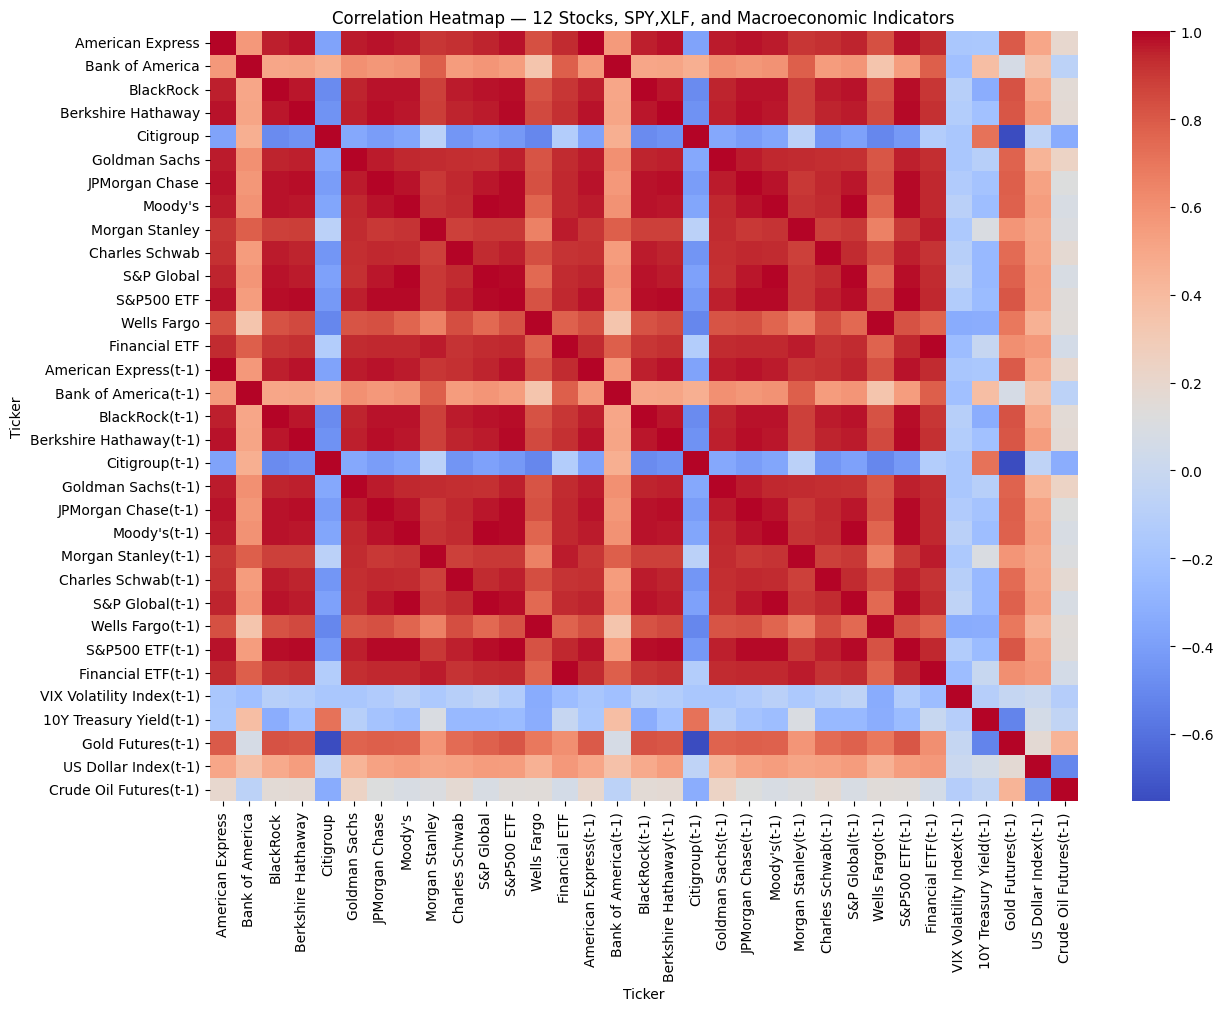

In [ ]:
# 2. CORRELATION HEATMAP

plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap — 12 Stocks, SPY,XLF, and Macroeconomic Indicators")
plt.show()

### 📈 Plotting Stock and Market Index Price Levels Over Time

This line plot visualizes the historical price evolution of:

- Financial sector stocks  
- Benchmark ETFs (SPY and XLF)  
- Macroeconomic indicators  

Lagged (t-1) features are intentionally excluded to keep the plot focused on **actual observed prices** rather than engineered variables.

---

### 🎯 Why This Visualization Is Important

This chart helps us understand:

- **Long-term market trends**  
- **Relative performance** of financial institutions  
- **Market shocks** (e.g., 2008, 2020 COVID crash)  
- **Volatility differences** between assets  
- Macro indicators like VIX behaving differently from stock prices  

This builds intuition about the dataset before applying machine learning models.

---

### 🎨 Color Mapping

We use a colormap (`tab20`) to assign each line a unique and distinguishable color:

```python
colors = plt.cm.get_cmap('tab20', len(plot_cols))


/tmp/ipython-input-3969464274.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(plot_cols))  # 'tab20', 'nipy_spectral', 'turbo', 'rainbow' also work


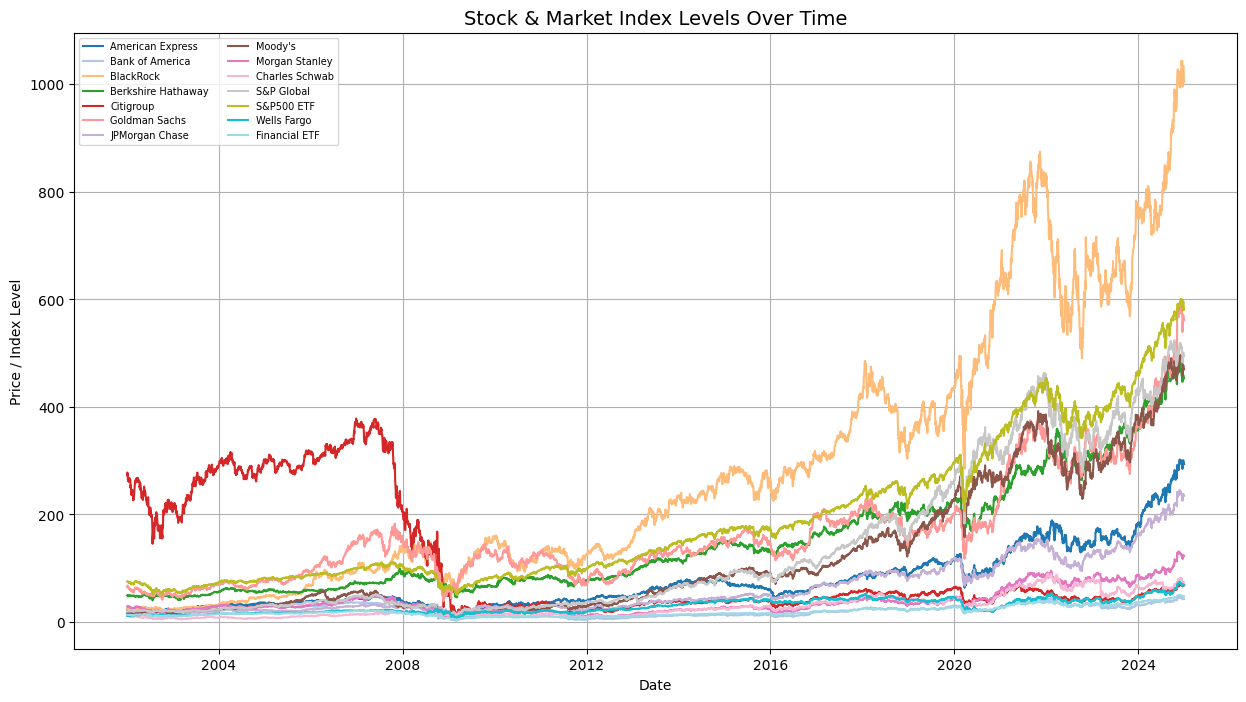

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Filter tickers (exclude *_t-1 columns)
plot_cols = [col for col in df.columns if "(t-1)" not in col]

plt.figure(figsize=(15,8))

# Generate unique colors using a large colormap
colors = plt.cm.get_cmap('tab20', len(plot_cols))  # 'tab20', 'nipy_spectral', 'turbo', 'rainbow' also work

for i, col in enumerate(plot_cols):
    plt.plot(df.index, df[col], label=col, color=colors(i))

plt.title("Stock & Market Index Levels Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price / Index Level")
plt.legend(loc="upper left", fontsize=7, ncol=2)
plt.grid(True)
plt.show()


In [ ]:
df

Ticker,American Express,Bank of America,BlackRock,Berkshire Hathaway,Citigroup,Goldman Sachs,JPMorgan Chase,Moody's,Morgan Stanley,Charles Schwab,...,Charles Schwab(t-1),S&P Global(t-1),Wells Fargo(t-1),S&P500 ETF(t-1),Financial ETF(t-1),VIX Volatility Index(t-1),10Y Treasury Yield(t-1),Gold Futures(t-1),US Dollar Index(t-1),Crude Oil Futures(t-1)
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-03,22.856510,17.530474,24.787601,49.400002,272.940247,64.899261,18.899746,15.701710,28.392756,12.257984,...,11.319540,19.655800,11.182113,74.703064,13.233000,22.709999,5.157,278.899994,115.790001,21.010000
2002-01-04,23.652870,17.803644,25.086819,49.139999,278.019348,67.917831,19.750538,16.007427,29.801889,13.160061,...,12.257984,19.840816,11.223298,75.550148,13.323667,21.340000,5.120,278.200012,116.110001,20.370001
2002-01-07,23.577625,17.591799,24.775620,49.180000,274.757965,67.215828,19.699884,15.760496,29.577026,12.614450,...,13.160061,20.019196,11.251609,76.054512,13.499969,20.450001,5.141,278.899994,116.330002,21.620001
2002-01-08,23.232740,17.310265,24.805561,47.759998,264.653046,64.934341,19.547970,16.148533,28.957409,12.396200,...,12.614450,20.012598,11.269632,75.517815,13.464711,21.940001,5.057,278.600006,116.330002,21.480000
2002-01-09,23.295450,17.268454,24.799568,48.500000,266.203674,65.811813,19.603674,15.807536,29.293535,12.527158,...,12.396200,19.986162,11.225873,75.343224,13.278327,21.830000,5.057,278.899994,116.830002,21.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,300.225830,43.375397,1033.641479,458.660004,69.083389,571.134155,237.286896,476.744598,123.599075,73.934486,...,73.806076,494.592957,69.039757,589.524414,47.922230,16.780001,4.599,2612.300049,108.040001,69.239998
2024-12-26,300.750153,43.541546,1033.102539,459.079987,69.423935,569.605286,238.099670,477.548431,124.542656,74.141960,...,73.934486,501.045227,70.067413,596.076965,48.486374,14.270000,4.591,2620.000000,108.260002,70.099998
2024-12-27,297.841522,43.336296,1023.205444,456.510010,69.083389,564.656372,236.170517,473.151978,123.307259,73.835701,...,74.141960,501.075012,70.233810,596.116699,48.605141,14.730000,4.579,2638.800049,108.129997,69.620003


In [ ]:
df.columns

Index(['American Express', 'Bank of America', 'BlackRock',
       'Berkshire Hathaway', 'Citigroup', 'Goldman Sachs', 'JPMorgan Chase',
       'Moody's', 'Morgan Stanley', 'Charles Schwab', 'S&P Global',
       'S&P500 ETF', 'Wells Fargo', 'Financial ETF', 'American Express(t-1)',
       'Bank of America(t-1)', 'BlackRock(t-1)', 'Berkshire Hathaway(t-1)',
       'Citigroup(t-1)', 'Goldman Sachs(t-1)', 'JPMorgan Chase(t-1)',
       'Moody's(t-1)', 'Morgan Stanley(t-1)', 'Charles Schwab(t-1)',
       'S&P Global(t-1)', 'Wells Fargo(t-1)', 'S&P500 ETF(t-1)',
       'Financial ETF(t-1)', 'VIX Volatility Index(t-1)',
       '10Y Treasury Yield(t-1)', 'Gold Futures(t-1)', 'US Dollar Index(t-1)',
       'Crude Oil Futures(t-1)'],
      dtype='object', name='Ticker')

### 🧹 Removing Same-Day ETF Prices

After generating lagged features such as:

- `S&P500 ETF(t-1)`
- `Financial ETF(t-1)`

we no longer want the model to have access to **same-day ETF price levels**, because:

- They would introduce **look-ahead bias**
- Tomorrow’s predictions should only use **information available up to today**
- Only the lagged versions should be part of the feature set

Thus, we remove the original ETF price columns:

```python
df = df.drop(columns=["S&P500 ETF", "Financial ETF"])


In [ ]:
df.columns

Index(['American Express', 'Bank of America', 'BlackRock',
       'Berkshire Hathaway', 'Citigroup', 'Goldman Sachs', 'JPMorgan Chase',
       'Moody's', 'Morgan Stanley', 'Charles Schwab', 'S&P Global',
       'S&P500 ETF', 'Wells Fargo', 'Financial ETF', 'American Express(t-1)',
       'Bank of America(t-1)', 'BlackRock(t-1)', 'Berkshire Hathaway(t-1)',
       'Citigroup(t-1)', 'Goldman Sachs(t-1)', 'JPMorgan Chase(t-1)',
       'Moody's(t-1)', 'Morgan Stanley(t-1)', 'Charles Schwab(t-1)',
       'S&P Global(t-1)', 'Wells Fargo(t-1)', 'S&P500 ETF(t-1)',
       'Financial ETF(t-1)', 'VIX Volatility Index(t-1)',
       '10Y Treasury Yield(t-1)', 'Gold Futures(t-1)', 'US Dollar Index(t-1)',
       'Crude Oil Futures(t-1)'],
      dtype='object', name='Ticker')

In [ ]:
df = df.drop(columns=["S&P500 ETF", "Financial ETF"])


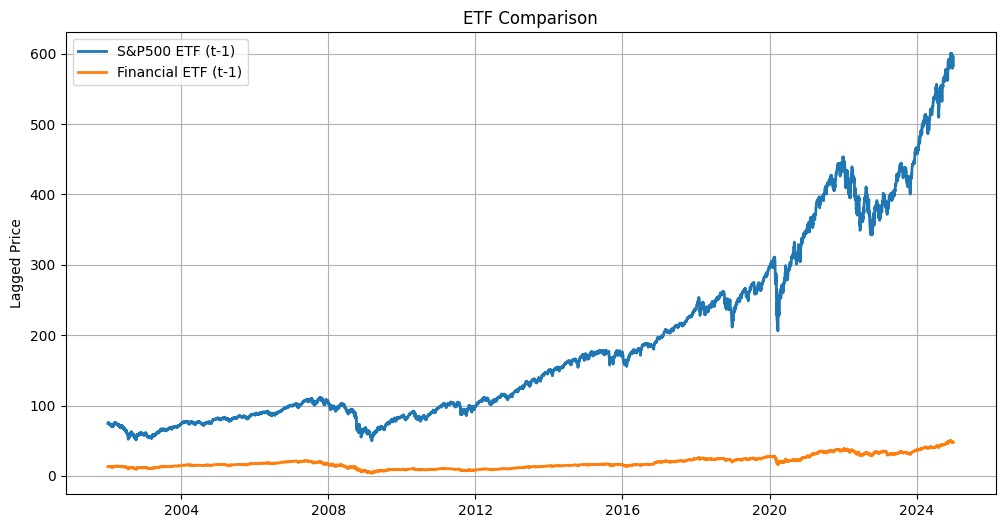

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df["S&P500 ETF(t-1)"], label="S&P500 ETF (t-1)", linewidth=2)
plt.plot(df.index, df["Financial ETF(t-1)"], label="Financial ETF (t-1)", linewidth=2)

plt.title("ETF Comparison")
plt.ylabel("Lagged Price")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
df

Ticker,American Express,Bank of America,BlackRock,Berkshire Hathaway,Citigroup,Goldman Sachs,JPMorgan Chase,Moody's,Morgan Stanley,Charles Schwab,...,Charles Schwab(t-1),S&P Global(t-1),Wells Fargo(t-1),S&P500 ETF(t-1),Financial ETF(t-1),VIX Volatility Index(t-1),10Y Treasury Yield(t-1),Gold Futures(t-1),US Dollar Index(t-1),Crude Oil Futures(t-1)
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-03,22.856510,17.530474,24.787601,49.400002,272.940247,64.899261,18.899746,15.701710,28.392756,12.257984,...,11.319540,19.655800,11.182113,74.703064,13.233000,22.709999,5.157,278.899994,115.790001,21.010000
2002-01-04,23.652870,17.803644,25.086819,49.139999,278.019348,67.917831,19.750538,16.007427,29.801889,13.160061,...,12.257984,19.840816,11.223298,75.550148,13.323667,21.340000,5.120,278.200012,116.110001,20.370001
2002-01-07,23.577625,17.591799,24.775620,49.180000,274.757965,67.215828,19.699884,15.760496,29.577026,12.614450,...,13.160061,20.019196,11.251609,76.054512,13.499969,20.450001,5.141,278.899994,116.330002,21.620001
2002-01-08,23.232740,17.310265,24.805561,47.759998,264.653046,64.934341,19.547970,16.148533,28.957409,12.396200,...,12.614450,20.012598,11.269632,75.517815,13.464711,21.940001,5.057,278.600006,116.330002,21.480000
2002-01-09,23.295450,17.268454,24.799568,48.500000,266.203674,65.811813,19.603674,15.807536,29.293535,12.527158,...,12.396200,19.986162,11.225873,75.343224,13.278327,21.830000,5.057,278.899994,116.830002,21.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,300.225830,43.375397,1033.641479,458.660004,69.083389,571.134155,237.286896,476.744598,123.599075,73.934486,...,73.806076,494.592957,69.039757,589.524414,47.922230,16.780001,4.599,2612.300049,108.040001,69.239998
2024-12-26,300.750153,43.541546,1033.102539,459.079987,69.423935,569.605286,238.099670,477.548431,124.542656,74.141960,...,73.934486,501.045227,70.067413,596.076965,48.486374,14.270000,4.591,2620.000000,108.260002,70.099998
2024-12-27,297.841522,43.336296,1023.205444,456.510010,69.083389,564.656372,236.170517,473.151978,123.307259,73.835701,...,74.141960,501.075012,70.233810,596.116699,48.605141,14.730000,4.579,2638.800049,108.129997,69.620003


### 📈 Creating Technical Indicators: Moving Averages and Volatility

Technical indicators are widely used in financial modeling because they capture:

- **Trend** (moving averages)
- **Momentum**
- **Short-term volatility**
- **Mean reversion patterns**

In this step, we engineer three types of features for each raw price series.

---

### 🔍 Selecting Only Non-Lagged Columns

We first filter out columns that contain “(t-1)” because:

- Lagged columns already represent past information  
- Technical indicators should be built on *actual* price series  
- Avoids creating redundant or leaked features  

```python
stock_cols = [c for c in df.columns if "(t-1)" not in c]


In [ ]:
# Select only stocks without lag columns
stock_cols = [c for c in df.columns if "(t-1)" not in c]

for col in stock_cols:
    df[f"{col}_MA5"]  = df[col].rolling(5).mean().shift(1)     # 5-day MA
    df[f"{col}_MA10"] = df[col].rolling(10).mean().shift(1)    # 10-day MA
    df[f"{col}_Vol5"] = df[col].pct_change(5).rolling(5).std().shift(1)  # 5-day volatility


In [ ]:
df

Ticker,American Express,Bank of America,BlackRock,Berkshire Hathaway,Citigroup,Goldman Sachs,JPMorgan Chase,Moody's,Morgan Stanley,Charles Schwab,...,Morgan Stanley_Vol5,Charles Schwab_MA5,Charles Schwab_MA10,Charles Schwab_Vol5,S&P Global_MA5,S&P Global_MA10,S&P Global_Vol5,Wells Fargo_MA5,Wells Fargo_MA10,Wells Fargo_Vol5
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-03,22.856510,17.530474,24.787601,49.400002,272.940247,64.899261,18.899746,15.701710,28.392756,12.257984,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-04,23.652870,17.803644,25.086819,49.139999,278.019348,67.917831,19.750538,16.007427,29.801889,13.160061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-07,23.577625,17.591799,24.775620,49.180000,274.757965,67.215828,19.699884,15.760496,29.577026,12.614450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-08,23.232740,17.310265,24.805561,47.759998,264.653046,64.934341,19.547970,16.148533,28.957409,12.396200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-09,23.295450,17.268454,24.799568,48.500000,266.203674,65.811813,19.603674,15.807536,29.293535,12.527158,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,300.225830,43.375397,1033.641479,458.660004,69.083389,571.134155,237.286896,476.744598,123.599075,73.934486,...,0.025520,73.770506,76.901165,0.028755,489.830157,498.033496,0.018346,68.374211,69.115113,0.014051
2024-12-26,300.750153,43.541546,1033.102539,459.079987,69.423935,569.605286,238.099670,477.548431,124.542656,74.141960,...,0.020502,73.391150,76.162213,0.037481,490.671930,497.298926,0.026081,68.526892,69.070091,0.020314
2024-12-27,297.841522,43.336296,1023.205444,456.510010,69.083389,564.656372,236.170517,473.151978,123.307259,73.835701,...,0.044459,73.604536,75.435118,0.046908,493.580426,496.158362,0.031413,69.114133,69.085752,0.028193


In [ ]:
df = df.dropna()
df

Ticker,American Express,Bank of America,BlackRock,Berkshire Hathaway,Citigroup,Goldman Sachs,JPMorgan Chase,Moody's,Morgan Stanley,Charles Schwab,...,Morgan Stanley_Vol5,Charles Schwab_MA5,Charles Schwab_MA10,Charles Schwab_Vol5,S&P Global_MA5,S&P Global_MA10,S&P Global_Vol5,Wells Fargo_MA5,Wells Fargo_MA10,Wells Fargo_Vol5
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-17,23.301725,17.037092,25.673296,49.900002,266.791534,63.166641,18.661726,15.646837,28.917265,11.290443,...,0.036726,11.734201,12.162686,0.041031,20.394473,20.175122,0.009630,11.349945,11.288937,0.029063
2002-01-18,23.213926,16.947897,25.284313,49.980000,267.112427,62.709717,18.185680,15.638990,28.405548,10.817579,...,0.018996,11.571247,12.065932,0.027684,20.511416,20.266628,0.009500,11.460119,11.340678,0.032041
2002-01-21,23.213926,16.947897,25.284313,49.980000,267.112427,62.709717,18.185680,15.638990,28.405548,10.817579,...,0.019471,11.268616,11.831684,0.031743,20.599949,20.339304,0.007924,11.567205,11.383667,0.028338
2002-01-22,23.345613,17.469156,24.895321,49.599998,263.049164,61.142128,18.109720,15.576284,27.768406,10.271979,...,0.019552,11.101296,11.651996,0.032298,20.689143,20.412640,0.005494,11.688705,11.424854,0.005731
2002-01-23,22.856510,17.522114,25.134705,49.000000,264.653046,61.331944,18.104660,15.533163,27.823591,10.075560,...,0.020106,10.826311,11.439574,0.029306,20.766447,20.520005,0.005040,11.758208,11.503623,0.009419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,300.225830,43.375397,1033.641479,458.660004,69.083389,571.134155,237.286896,476.744598,123.599075,73.934486,...,0.025520,73.770506,76.901165,0.028755,489.830157,498.033496,0.018346,68.374211,69.115113,0.014051
2024-12-26,300.750153,43.541546,1033.102539,459.079987,69.423935,569.605286,238.099670,477.548431,124.542656,74.141960,...,0.020502,73.391150,76.162213,0.037481,490.671930,497.298926,0.026081,68.526892,69.070091,0.020314
2024-12-27,297.841522,43.336296,1023.205444,456.510010,69.083389,564.656372,236.170517,473.151978,123.307259,73.835701,...,0.044459,73.604536,75.435118,0.046908,493.580426,496.158362,0.031413,69.114133,69.085752,0.028193


In [ ]:
df.columns

Index(['American Express', 'Bank of America', 'BlackRock',
       'Berkshire Hathaway', 'Citigroup', 'Goldman Sachs', 'JPMorgan Chase',
       'Moody's', 'Morgan Stanley', 'Charles Schwab', 'S&P Global',
       'Wells Fargo', 'American Express(t-1)', 'Bank of America(t-1)',
       'BlackRock(t-1)', 'Berkshire Hathaway(t-1)', 'Citigroup(t-1)',
       'Goldman Sachs(t-1)', 'JPMorgan Chase(t-1)', 'Moody's(t-1)',
       'Morgan Stanley(t-1)', 'Charles Schwab(t-1)', 'S&P Global(t-1)',
       'Wells Fargo(t-1)', 'S&P500 ETF(t-1)', 'Financial ETF(t-1)',
       'VIX Volatility Index(t-1)', '10Y Treasury Yield(t-1)',
       'Gold Futures(t-1)', 'US Dollar Index(t-1)', 'Crude Oil Futures(t-1)',
       'American Express_MA5', 'American Express_MA10',
       'American Express_Vol5', 'Bank of America_MA5', 'Bank of America_MA10',
       'Bank of America_Vol5', 'BlackRock_MA5', 'BlackRock_MA10',
       'BlackRock_Vol5', 'Berkshire Hathaway_MA5', 'Berkshire Hathaway_MA10',
       'Berkshire Hathaway_

In [ ]:
df.isnull().sum()

,0
Ticker,
American Express,0
Bank of America,0
BlackRock,0
Berkshire Hathaway,0
Citigroup,0
...,...
S&P Global_MA10,0
S&P Global_Vol5,0
Wells Fargo_MA5,0


In [ ]:
df.columns


Index(['American Express', 'Bank of America', 'BlackRock',
       'Berkshire Hathaway', 'Citigroup', 'Goldman Sachs', 'JPMorgan Chase',
       'Moody's', 'Morgan Stanley', 'Charles Schwab', 'S&P Global',
       'Wells Fargo', 'American Express(t-1)', 'Bank of America(t-1)',
       'BlackRock(t-1)', 'Berkshire Hathaway(t-1)', 'Citigroup(t-1)',
       'Goldman Sachs(t-1)', 'JPMorgan Chase(t-1)', 'Moody's(t-1)',
       'Morgan Stanley(t-1)', 'Charles Schwab(t-1)', 'S&P Global(t-1)',
       'Wells Fargo(t-1)', 'S&P500 ETF(t-1)', 'Financial ETF(t-1)',
       'VIX Volatility Index(t-1)', '10Y Treasury Yield(t-1)',
       'Gold Futures(t-1)', 'US Dollar Index(t-1)', 'Crude Oil Futures(t-1)',
       'American Express_MA5', 'American Express_MA10',
       'American Express_Vol5', 'Bank of America_MA5', 'Bank of America_MA10',
       'Bank of America_Vol5', 'BlackRock_MA5', 'BlackRock_MA10',
       'BlackRock_Vol5', 'Berkshire Hathaway_MA5', 'Berkshire Hathaway_MA10',
       'Berkshire Hathaway_

### 🎯 Defining the Target Columns (Prediction Targets)

In this step, we specify which variables the machine learning model will predict.  
These are the **11 major financial stocks** in the S&P 500:

- American Express  
- Bank of America  
- BlackRock  
- Berkshire Hathaway  
- Citigroup  
- Goldman Sachs  
- JPMorgan Chase  
- Moody’s  
- Morgan Stanley  
- Charles Schwab  
- Wells Fargo  

---

### ✔ Why only these?

We exclude:

- ETFs (SPY, XLF)  
- Macroeconomic indicators  
- Lagged/engineered features  

because these are used **as inputs**, not outputs.

---

### ✔ Purpose of `target_cols`

By creating this list, we ensure:

- Clear separation between **predictors (X)** and **targets (y)**
- Consistency across Linear Regression, Random Forest, and XGBoost models
- Easy multi-output modeling (predict all 11 stocks simultaneously)

This makes the modeling pipeline scalable, organized, and easy to maintain.


In [ ]:
target_cols = [
    'American Express', 'Bank of America', 'BlackRock', 'Berkshire Hathaway',
    'Citigroup', 'Goldman Sachs', 'JPMorgan Chase', "Moody's",
    'Morgan Stanley', 'Charles Schwab', 'Wells Fargo'
]

In [ ]:
corr = df.corr()

### 🔍 Finding Top Correlated Signals for Each Target Stock

This section helps us understand which features have the strongest relationships with each financial stock.

We loop through every stock in `target_cols` and print the **top 8 most positively correlated variables** from the correlation matrix.

---

### ⭐ Why This Step Matters

Correlation analysis provides essential early insights:

- Identifies **leading indicators** for each stock  
- Helps validate whether the dataset contains meaningful signals  
- Highlights **redundant or highly collinear variables**  
- Guides feature engineering and selection  
- Builds intuition about stock behavior and market structure  

---

### 📌 What the Output Shows

For each stock (e.g., *JPMorgan Chase*), you will see lines like:



In [ ]:
for stock in target_cols:
    print("\nTop signals for:", stock)
    print(corr[stock].sort_values(ascending=False).head(8))


Top signals for: American Express
Ticker
American Express           1.000000
American Express(t-1)      0.999555
American Express_MA5       0.999045
American Express_MA10      0.998426
Berkshire Hathaway         0.978272
S&P500 ETF(t-1)            0.978235
JPMorgan Chase             0.978115
Berkshire Hathaway(t-1)    0.978078
Name: American Express, dtype: float64

Top signals for: Bank of America
Ticker
Bank of America         1.000000
Bank of America(t-1)    0.998903
Bank of America_MA5     0.997612
Bank of America_MA10    0.995989
Morgan Stanley          0.786162
Morgan Stanley(t-1)     0.785872
Morgan Stanley_MA5      0.785755
Morgan Stanley_MA10     0.785614
Name: Bank of America, dtype: float64

Top signals for: BlackRock
Ticker
BlackRock          1.000000
BlackRock(t-1)     0.999697
BlackRock_MA5      0.999345
BlackRock_MA10     0.998835
S&P500 ETF(t-1)    0.985819
Moody's            0.976702
Moody's(t-1)       0.976534
Moody's_MA5        0.976428
Name: BlackRock, dtype: float

### 🧩 Creating the Feature Matrix (X) and Target Matrix (y)

In this step, we formally separate the dataset into **inputs (X)** and **outputs (y)** for machine learning.

---

### ✔ What is `X`?

`X` contains all **predictive features**, including:

- Lagged stock prices  
- Lagged macroeconomic indicators  
- Moving averages (MA5, MA10)  
- Rolling volatility features  
- ETF lagged values  
- Any engineered indicators  

These features are used by the ML models to learn patterns.

---

### ✔ What is `y`?

`y` contains the **true stock prices** we want to predict:



In [ ]:
X = df.drop(columns=target_cols)   # make sure it's a dataframe
y = df[target_cols]

In [ ]:
X

Ticker,S&P Global,American Express(t-1),Bank of America(t-1),BlackRock(t-1),Berkshire Hathaway(t-1),Citigroup(t-1),Goldman Sachs(t-1),JPMorgan Chase(t-1),Moody's(t-1),Morgan Stanley(t-1),...,Morgan Stanley_Vol5,Charles Schwab_MA5,Charles Schwab_MA10,Charles Schwab_Vol5,S&P Global_MA5,S&P Global_MA10,S&P Global_Vol5,Wells Fargo_MA5,Wells Fargo_MA10,Wells Fargo_Vol5
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-17,20.755878,22.975641,16.947897,25.140678,49.639999,261.231323,62.217644,18.489540,15.603722,28.029268,...,0.036726,11.734201,12.162686,0.041031,20.394473,20.175122,0.009630,11.349945,11.288937,0.029063
2002-01-18,20.745958,23.301725,17.037092,25.673296,49.900002,266.791534,63.166641,18.661726,15.646837,28.917265,...,0.018996,11.571247,12.065932,0.027684,20.511416,20.266628,0.009500,11.460119,11.340678,0.032041
2002-01-21,20.745958,23.213926,16.947897,25.284313,49.980000,267.112427,62.709717,18.185680,15.638990,28.405548,...,0.019471,11.268616,11.831684,0.031743,20.599949,20.339304,0.007924,11.567205,11.383667,0.028338
2002-01-22,21.059805,23.213926,16.947897,25.284313,49.980000,267.112427,62.709717,18.185680,15.638990,28.405548,...,0.019552,11.101296,11.651996,0.032298,20.689143,20.412640,0.005494,11.688705,11.424854,0.005731
2002-01-23,20.633646,23.345613,17.469156,24.895321,49.599998,263.049164,61.142128,18.109720,15.576284,27.768406,...,0.020106,10.826311,11.439574,0.029306,20.766447,20.520005,0.005040,11.758208,11.503623,0.009419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,501.045227,295.615509,42.896481,1018.815308,454.350006,67.886589,559.364380,233.448151,470.174683,121.060181,...,0.025520,73.770506,76.901165,0.028755,489.830157,498.033496,0.018346,68.374211,69.115113,0.014051
2024-12-26,501.075012,300.225830,43.375397,1033.641479,458.660004,69.083389,571.134155,237.286896,476.744598,123.599075,...,0.020502,73.391150,76.162213,0.037481,490.671930,497.298926,0.026081,68.526892,69.070091,0.020314
2024-12-27,498.116882,300.750153,43.541546,1033.102539,459.079987,69.423935,569.605286,238.099670,477.548431,124.542656,...,0.044459,73.604536,75.435118,0.046908,493.580426,496.158362,0.031413,69.114133,69.085752,0.028193


In [ ]:
X.columns

Index(['S&P Global', 'American Express(t-1)', 'Bank of America(t-1)',
       'BlackRock(t-1)', 'Berkshire Hathaway(t-1)', 'Citigroup(t-1)',
       'Goldman Sachs(t-1)', 'JPMorgan Chase(t-1)', 'Moody's(t-1)',
       'Morgan Stanley(t-1)', 'Charles Schwab(t-1)', 'S&P Global(t-1)',
       'Wells Fargo(t-1)', 'S&P500 ETF(t-1)', 'Financial ETF(t-1)',
       'VIX Volatility Index(t-1)', '10Y Treasury Yield(t-1)',
       'Gold Futures(t-1)', 'US Dollar Index(t-1)', 'Crude Oil Futures(t-1)',
       'American Express_MA5', 'American Express_MA10',
       'American Express_Vol5', 'Bank of America_MA5', 'Bank of America_MA10',
       'Bank of America_Vol5', 'BlackRock_MA5', 'BlackRock_MA10',
       'BlackRock_Vol5', 'Berkshire Hathaway_MA5', 'Berkshire Hathaway_MA10',
       'Berkshire Hathaway_Vol5', 'Citigroup_MA5', 'Citigroup_MA10',
       'Citigroup_Vol5', 'Goldman Sachs_MA5', 'Goldman Sachs_MA10',
       'Goldman Sachs_Vol5', 'JPMorgan Chase_MA5', 'JPMorgan Chase_MA10',
       'JPMorgan Chas

In [ ]:
y

Ticker,American Express,Bank of America,BlackRock,Berkshire Hathaway,Citigroup,Goldman Sachs,JPMorgan Chase,Moody's,Morgan Stanley,Charles Schwab,Wells Fargo
Date,,,,,,,,,,,
2002-01-17,23.301725,17.037092,25.673296,49.900002,266.791534,63.166641,18.661726,15.646837,28.917265,11.290443,11.740703
2002-01-18,23.213926,16.947897,25.284313,49.980000,267.112427,62.709717,18.185680,15.638990,28.405548,10.817579,11.681500
2002-01-21,23.213926,16.947897,25.284313,49.980000,267.112427,62.709717,18.185680,15.638990,28.405548,10.817579,11.681500
2002-01-22,23.345613,17.469156,24.895321,49.599998,263.049164,61.142128,18.109720,15.576284,27.768406,10.271979,12.013563
2002-01-23,22.856510,17.522114,25.134705,49.000000,264.653046,61.331944,18.104660,15.533163,27.823591,10.075560,12.088217
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,300.225830,43.375397,1033.641479,458.660004,69.083389,571.134155,237.286896,476.744598,123.599075,73.934486,70.067413
2024-12-26,300.750153,43.541546,1033.102539,459.079987,69.423935,569.605286,238.099670,477.548431,124.542656,74.141960,70.233810
2024-12-27,297.841522,43.336296,1023.205444,456.510010,69.083389,564.656372,236.170517,473.151978,123.307259,73.835701,69.597641


In [ ]:
y.columns

Index(['American Express', 'Bank of America', 'BlackRock',
       'Berkshire Hathaway', 'Citigroup', 'Goldman Sachs', 'JPMorgan Chase',
       'Moody's', 'Morgan Stanley', 'Charles Schwab', 'Wells Fargo'],
      dtype='object', name='Ticker')

### 🌲 Random Forest Feature Importance

This step uses a **Random Forest Regressor** to measure how important each feature is for predicting the set of 11 financial stocks.

Random Forests work by building many decision trees and averaging predictions.  
During training, each split in each tree is chosen to reduce prediction error.  
The more often a feature participates in high-quality splits, the more "important" it becomes.

---

### 🧠 Why Feature Importance Matters

Feature importance helps us:

- Understand which signals are driving predictions
- Identify the strongest leading indicators for financial stocks
- Reduce dimensionality by keeping only the best predictors
- Improve model performance by eliminating noise
- Validate earlier correlation insights with model-based evidence

---

### ⚙️ Model Configuration

- `n_estimators=400` — 400 trees for stable importance estimates  
- `max_depth=None` — deep trees capture complex stock–macro relationships  
- `n_jobs=-1` — use all CPU cores  
- `random_state=42` — reproducibility  

---

### 📌 Extracting Importances

We convert the model’s importances into a pandas Series:

```python
feature_importance = (
    pd.Series(rf.feature_importances_, index=X.columns)
      .sort_values(ascending=False)
)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X, y)

importances = rf.feature_importances_
feature_importance = (
    pd.Series(importances, index=X.columns)
    .sort_values(ascending=False)
)

feature_importance.head(25)

,0
Ticker,
BlackRock(t-1),0.558024
BlackRock_MA5,0.124188
Citigroup_MA5,0.055909
Goldman Sachs_MA5,0.049304
Citigroup_MA10,0.042279
S&P500 ETF(t-1),0.038699
Citigroup(t-1),0.036493
Goldman Sachs(t-1),0.026490
BlackRock_MA10,0.008622


In [ ]:
feature_importance

,0
Ticker,
BlackRock(t-1),0.558024
BlackRock_MA5,0.124188
Citigroup_MA5,0.055909
Goldman Sachs_MA5,0.049304
Citigroup_MA10,0.042279
S&P500 ETF(t-1),0.038699
Citigroup(t-1),0.036493
Goldman Sachs(t-1),0.026490
BlackRock_MA10,0.008622


### 🎯 Selecting the Top 35 Most Important Features

After ranking all predictors using Random Forest feature importance,  
we select the **top 35 features** to build a more focused and efficient machine learning model.

---

### ✔ Why Use Feature Selection?

Using all features can:

- Introduce noise  
- Increase overfitting  
- Slow down training  
- Reduce model generalization  

By selecting the best predictors, the model becomes:

- More accurate  
- Less noisy  
- Faster to train  
- Easier to interpret  

---

### ⭐ Why 35 Features?

The top 35 is a balanced choice because:

- It captures the most predictive signals  
- It’s small enough for Linear Regression to remain stable  
- It reduces redundancy from auto-correlated stock/macro variables  
- It gives Random Forest and XGBoost a clean, powerful input set  

---

### 📌 Code Breakdown

```python
top_35_features = feature_importance.head(35).index.tolist()


In [ ]:
top_35_features = feature_importance.head(35).index.tolist()
X_reduced = X[top_35_features]

In [ ]:
print("Selected Features (Top 35):")
for f in top_35_features:
    print(f)


Selected Features (Top 35):
BlackRock(t-1)
BlackRock_MA5
Citigroup_MA5
Goldman Sachs_MA5
Citigroup_MA10
S&P500 ETF(t-1)
Citigroup(t-1)
Goldman Sachs(t-1)
BlackRock_MA10
Financial ETF(t-1)
Goldman Sachs_MA10
S&P Global_MA10
S&P Global
S&P Global_MA5
Berkshire Hathaway(t-1)
Moody's_MA5
JPMorgan Chase(t-1)
American Express(t-1)
Berkshire Hathaway_MA10
Moody's(t-1)
S&P Global(t-1)
Berkshire Hathaway_MA5
Moody's_MA10
JPMorgan Chase_MA5
Morgan Stanley(t-1)
JPMorgan Chase_MA10
Bank of America_MA10
Bank of America(t-1)
Bank of America_MA5
American Express_MA5
Gold Futures(t-1)
American Express_MA10
10Y Treasury Yield(t-1)
Morgan Stanley_MA10
Morgan Stanley_MA5


### 📘 Linear Regression — 5-Fold Time Series Cross-Validation

We apply a **multi-output Linear Regression model** to predict the next-day prices of all 11 financial stocks.  
Because our data is temporal, we use **TimeSeriesSplit**, which preserves chronological order and avoids leakage.

---

## 🔹 1. Training Across Folds

For each of the 5 folds:

- The model is trained on a growing historical window  
- Tested on the next unseen segment of data  
- Predictions are generated for all 11 stocks  
- Metrics (R², MSE, RMSE) are computed per stock  

This ensures realistic evaluation that aligns with financial time series constraints.

---

## 🔹 2. Metrics Computed

For each stock and each fold, we compute:

- **R² Score** – how well the model explains variance  
- **MSE** – average squared error  
- **RMSE** – root mean squared error  

These help us understand accuracy across long and short-term patterns.

---

## 🔹 3. Averaging R² Across All Folds

After completing all folds, we average R² across the 5 folds.  
This gives a stable, unbiased estimate of how predictable each stock is.

---

## 🔹 4. Selecting the Top 5 Most Predictable Stocks

We automatically rank the 11 stocks based on average R² and select the top 5.  
These stocks are later used in our:

- ML-Driven Portfolio Simulation  
- Trading Strategy  
- Benchmark Comparison (vs S&P 500)




In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

# --------------------------------------------------
# ⭐ Track R² across all folds for each stock
# --------------------------------------------------
r2_scores = {stock: [] for stock in y.columns}

tscv = TimeSeriesSplit(n_splits=5)

results_lr_prices = []   # stores (actual, predicted) for plotting later

fold = 1
for train_idx, test_idx in tscv.split(X_reduced):

    X_train, X_test = X_reduced.iloc[train_idx], X_reduced.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # -----------------------------
    # Model
    # -----------------------------
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # -----------------------------
    # Predictions
    # -----------------------------
    preds = pd.DataFrame(lr.predict(X_test),
                         columns=y.columns,
                         index=y_test.index)

    results_lr_prices.append((y_test, preds))  # save for fold-wise plots

    print(f"\n======================= 📘 FOLD {fold} RESULTS =======================")

    fold_metrics = {}

    # --------------------------------------------------------------
    # Compute metrics for every stock in this fold
    # --------------------------------------------------------------
    for stock in y.columns:
        actual = y_test[stock]
        predicted = preds[stock]

        mse = mean_squared_error(actual, predicted)
        rmse = sqrt(mse)
        r2 = r2_score(actual, predicted)

        fold_metrics[stock] = [r2, mse, rmse]

        # ⭐ Save each fold's R² for average later
        r2_scores[stock].append(r2)

    # Display fold results
    metrics_df = pd.DataFrame(fold_metrics,
                              index=["R² Score", "MSE", "RMSE"]).T
    print(metrics_df)

    fold += 1


# -------------------------------------------------------------
# ⭐ After all folds: Compute Average R² Across All 5 Folds
# -------------------------------------------------------------
avg_r2 = {stock: sum(vals)/len(vals) for stock, vals in r2_scores.items()}
avg_r2_df = pd.DataFrame.from_dict(avg_r2, orient='index',
                                   columns=["Average R²"])

avg_r2_df = avg_r2_df.sort_values(by="Average R²", ascending=False)

print("\n======================= 📊 AVERAGE R² ACROSS ALL FOLDS =======================")
print(avg_r2_df)


# -------------------------------------------------------------
# ⭐ Select Top 5 Most Predictable Stocks Automatically
# -------------------------------------------------------------
top5_stocks = avg_r2_df.head(5).index.tolist()

print("\n======================= ⭐ TOP 5 MOST PREDICTABLE STOCKS =======================")
print(top5_stocks)



======================= 📘 FOLD 1 RESULTS =======================
                     R² Score         MSE       RMSE
American Express     0.985611    1.698759   1.303364
Bank of America      0.993668    0.661034   0.813040
BlackRock            0.967220   16.026371   4.003295
Berkshire Hathaway   0.948169    6.871655   2.621384
Citigroup            0.983099  262.616695  16.205453
Goldman Sachs        0.953224   44.858868   6.697676
JPMorgan Chase       0.904058    1.607573   1.267901
Moody's              0.987143    2.341606   1.530231
Morgan Stanley       0.959370    4.845251   2.201193
Charles Schwab     -48.475874  295.945034  17.203053
Wells Fargo         -0.598878   15.662019   3.957527

======================= 📘 FOLD 2 RESULTS =======================
                    R² Score        MSE      RMSE
American Express    0.994145   0.420833  0.648716
Bank of America     0.877184   0.904581  0.951095
BlackRock           0.979141  12.201273  3.493032
Berkshire Hathaway  0.988962   1

### 📈 Actual vs Predicted Prices — Linear Regression (Fold 5)

This visualization compares the **true stock prices** against the **Linear Regression model's predictions** for each of the 11 financial stocks.

We plot **Fold 5 (the final fold)** because:

- It uses the most recent portion of the dataset  
- It reflects how the model behaves in real-world forward-in-time prediction  
- It is the best indicator of out-of-sample performance  

---

## 🔹 What Each Plot Shows

For each stock:

- **Blue solid line** → actual historical prices  
- **Orange dashed line** → predicted prices  
- X-axis → trading dates  
- Y-axis → stock price levels  

---

## 🔹 Why This Visualization Matters

This plot helps us evaluate:

- Trend-following ability  
- Prediction stability  
- Whether predictions lag actual movements  
- Systematic under/overestimation  
- Differences across stocks (more predictable vs less predictable)

---

## 🔹 Observations Typically Seen

- Large-cap financial stocks (JPM, BAC, GS) usually show smoother predictions  
- More volatile stocks (SCHW, MCO) show weaker predictions — lower R²  
- Linear Regression often captures broad trends but misses sharp movements  

This comparison provides a clear, visual understanding of model quality before moving on to more advanced models (Random Forest & XGBoost).



================ 📈 PLOTTING ALL STOCKS — FOLD 5 ONLY ================


=========== 📘 FOLD 5 ===========



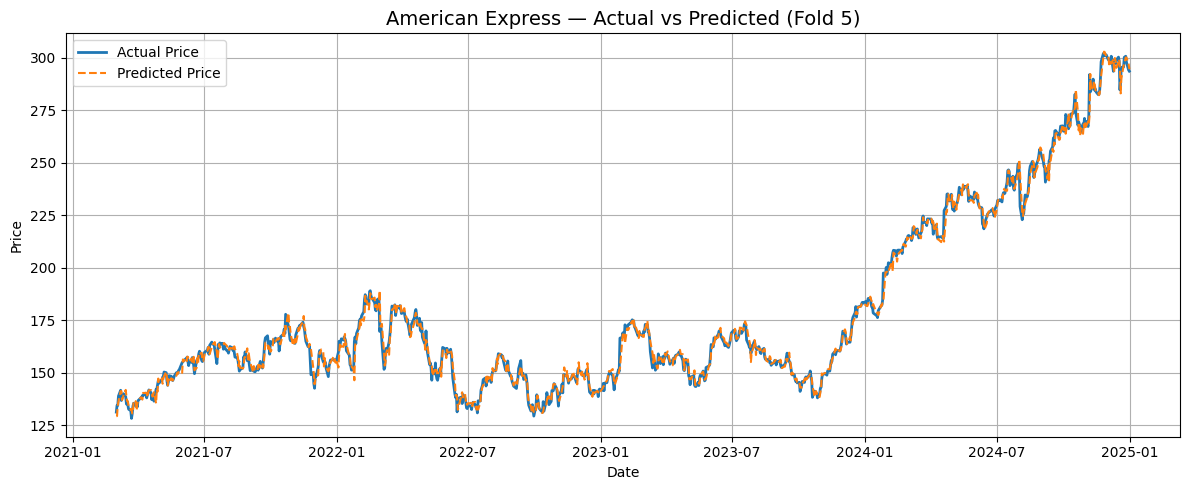

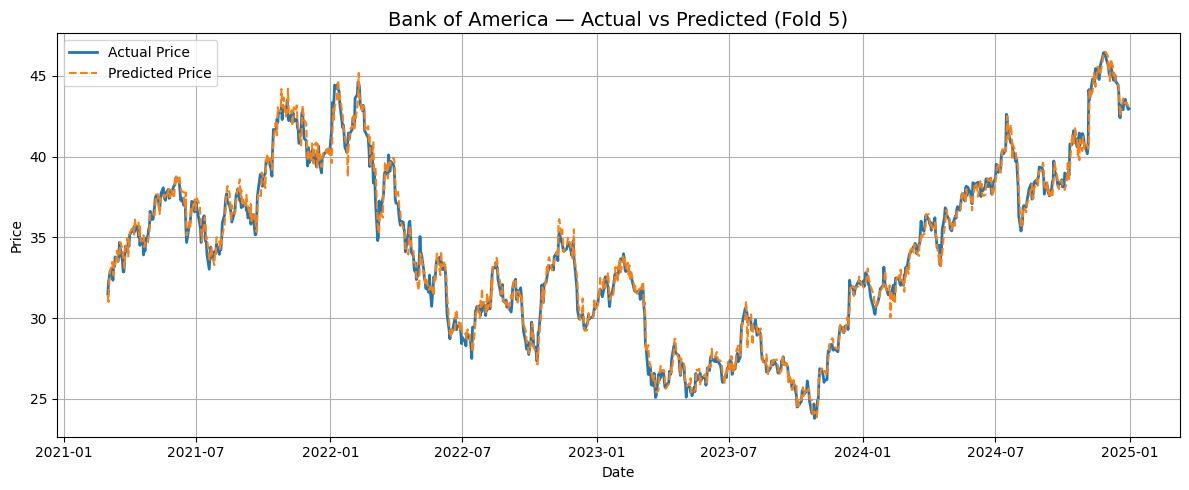

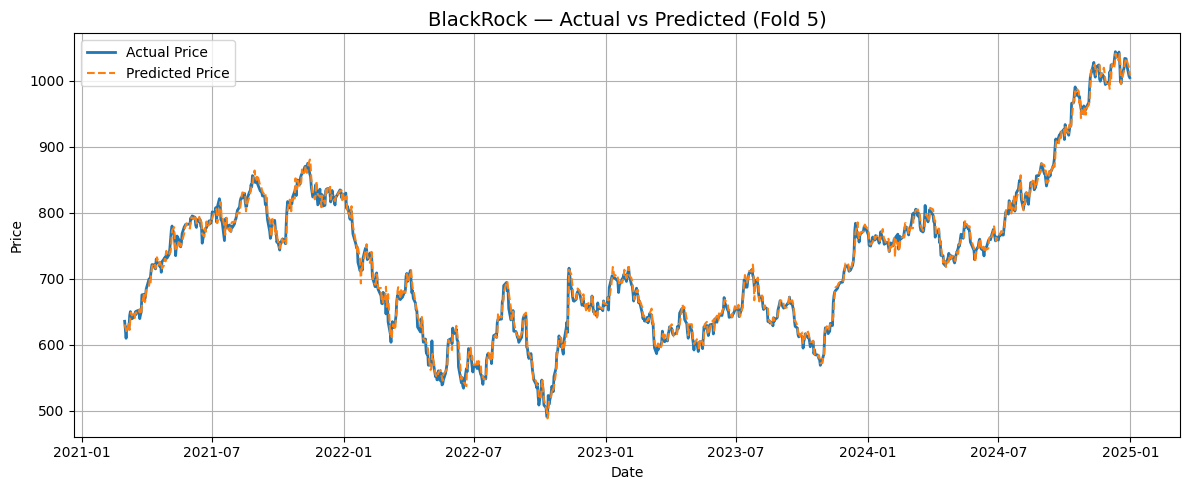

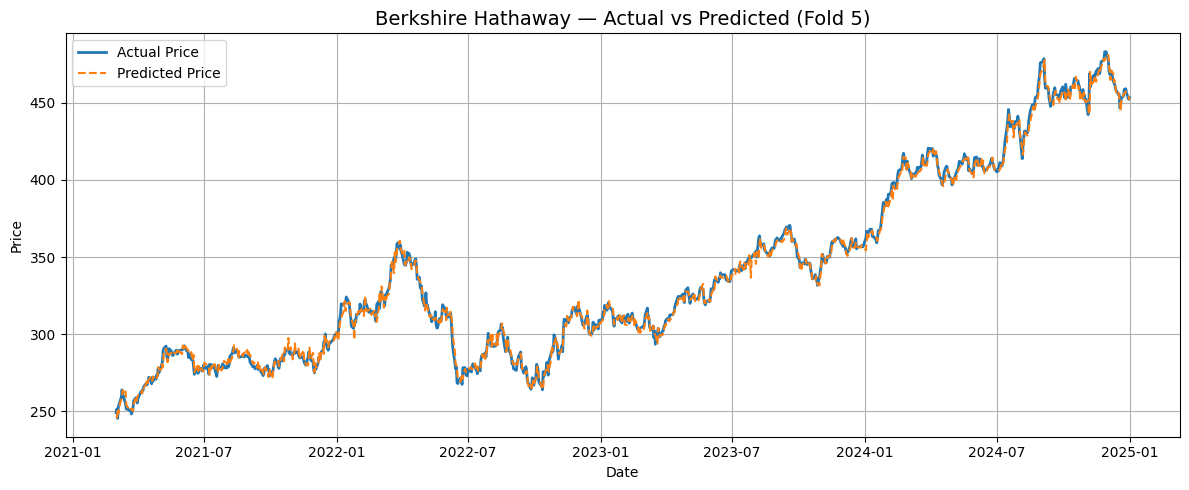

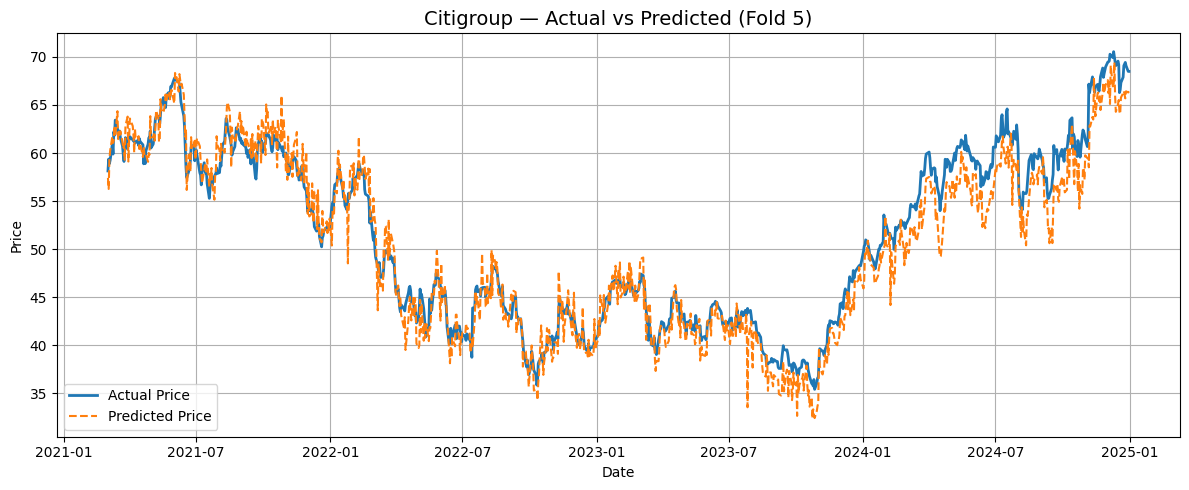

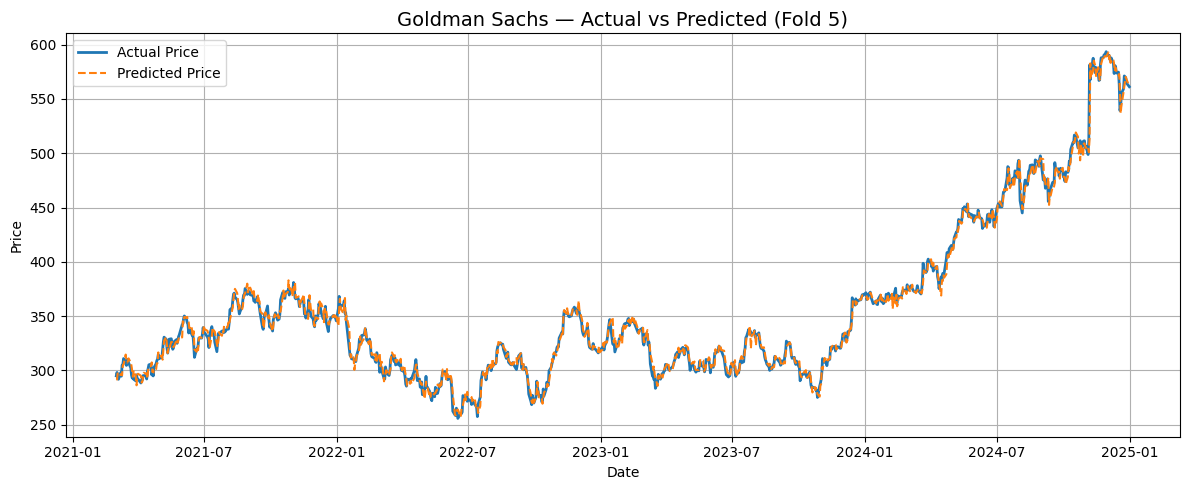

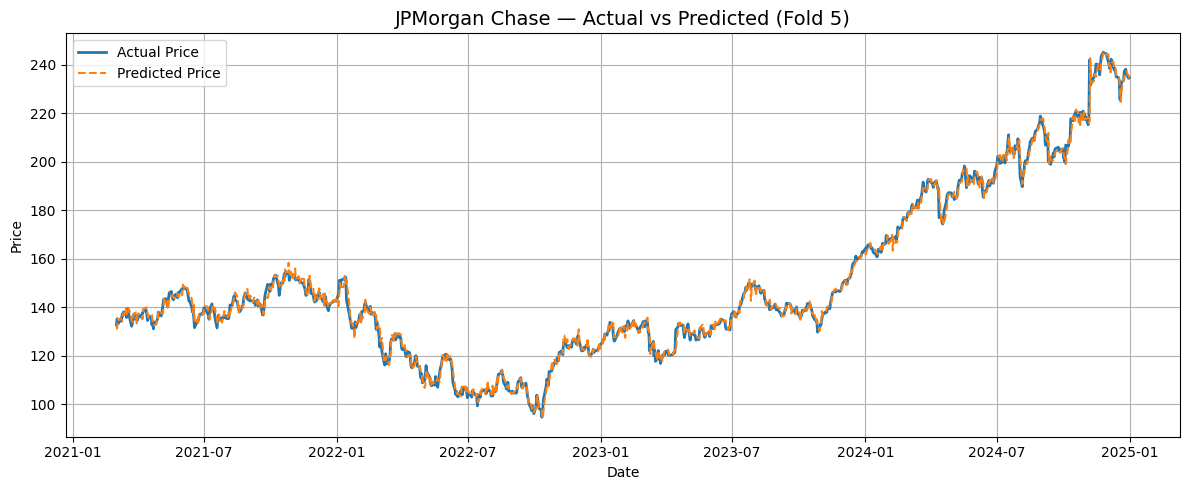

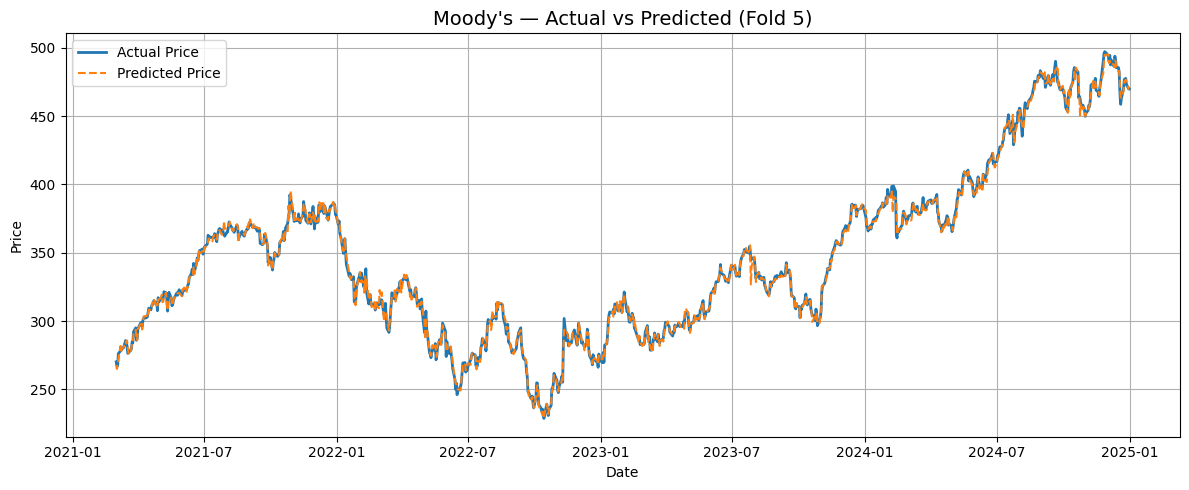

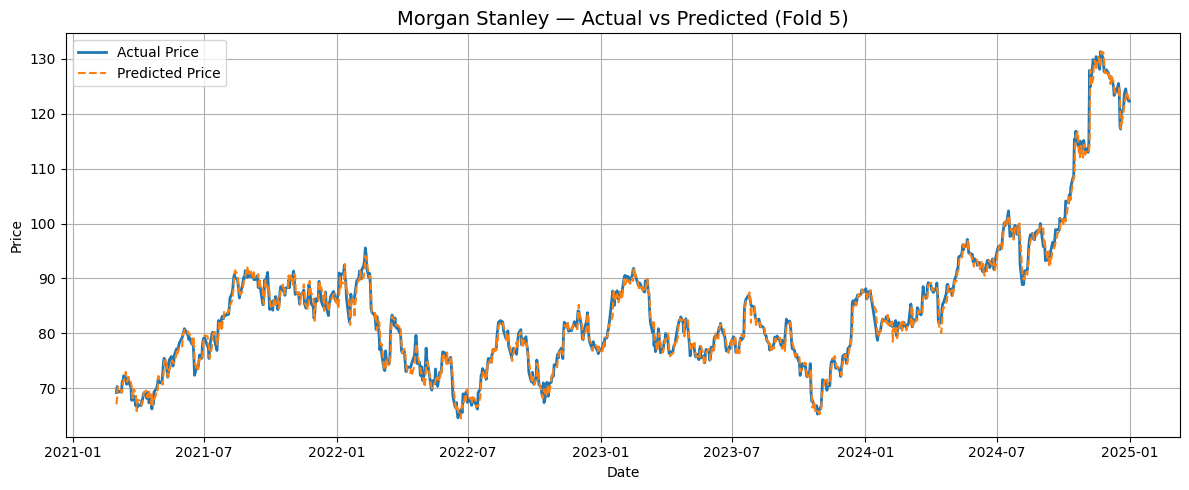

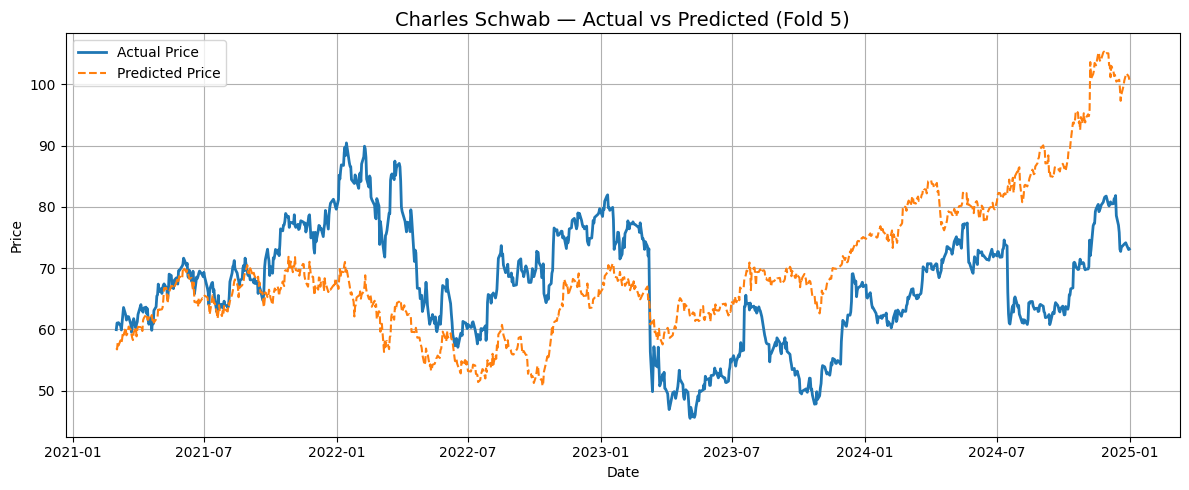

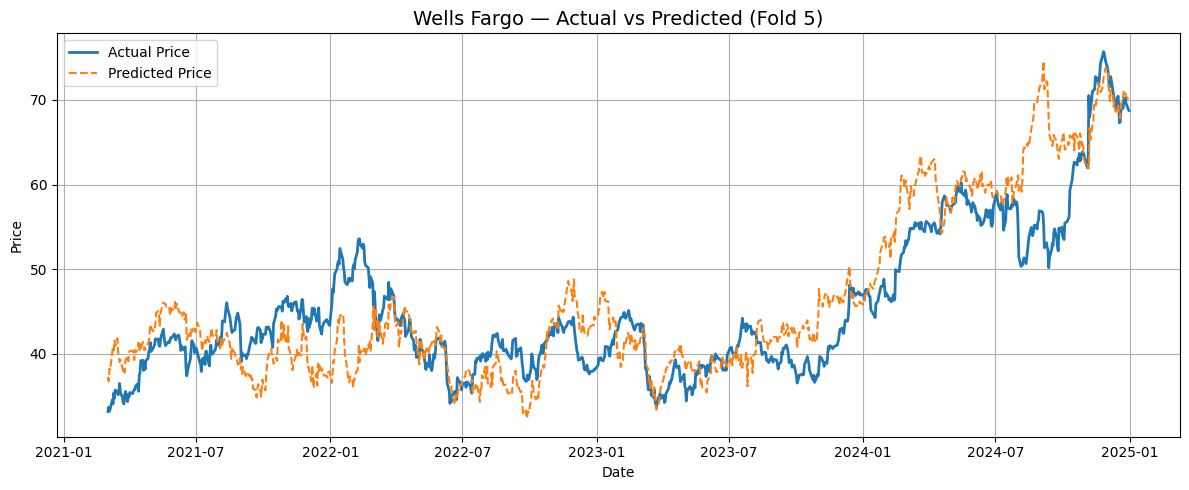

In [ ]:
import matplotlib.pyplot as plt

print("\n================ 📈 PLOTTING ALL STOCKS — FOLD 5 ONLY ================\n")

# Fold 5 is index 4
fold_idx = 4

actual_f, pred_f = results_lr_prices[fold_idx]

print(f"\n=========== 📘 FOLD {fold_idx+1} ===========\n")

for stock in y.columns:

    plt.figure(figsize=(12,5))

    plt.plot(actual_f[stock], label="Actual Price", linewidth=2)
    plt.plot(pred_f[stock], label="Predicted Price", linestyle='dashed')

    plt.title(f"{stock} — Actual vs Predicted (Fold {fold_idx+1})", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### 💼 Baseline Portfolio: Equal-Weighted Top 5 Predictable Stocks

Before running the ML-driven active trading strategy, we first construct a **simple baseline portfolio**.  
This portfolio invests equally (20% each) in the **top 5 most predictable stocks** as determined by the Linear Regression R² results.

This acts as a steady benchmark to compare against the ML strategy.

---

## 🔹 1. Select Portfolio Stocks

We take the 5 stocks with the **highest average R²** across the 5 time-series folds:

- These stocks are statistically the most “predictable”
- This improves stability and reduces noise
- The list is dynamically generated in the previous cell

---

## 🔹 2. Equal Weight Portfolio

We compute:

- Daily returns for each of the top 5 stocks  
- Apply equal weight of 20%  
- Combine them into a single daily return series  

This is done with:

```python
portfolio_returns = returns.mul(weights, axis=1).sum(axis=1)


In [ ]:
prices = y   # full historical prices for the 11 stocks
portfolio_prices = prices[top5_stocks]
returns = portfolio_prices.pct_change().dropna()
weights = [1/5] * 5
portfolio_returns = returns.mul(weights, axis=1).sum(axis=1)
portfolio_cum = (1 + portfolio_returns).cumprod()
sp500_prices = df["S&P Global"]     # correct benchmark
sp500_returns = sp500_prices.pct_change().dropna()
sp500_cum = (1 + sp500_returns).cumprod()

### 🤖 ML-Driven Active Portfolio Strategy — Fold 5 (Final Fold)

This section evaluates the performance of our **ML-driven trading strategy** using predictions from the Linear Regression model for **Fold 5**, which corresponds to the most recent segment of the time-series data.

Fold 5 represents the most realistic, fully out-of-sample environment.

---

## 🔹 1. Using the Top 5 Most Predictable Stocks
We previously computed R² across all folds and identified the 5 stocks with the highest predictability.  
These stocks form the basis of our ML-active portfolio.

---

## 🔹 2. Predicted Returns vs Real Returns
- Predicted returns are computed from predicted prices  
- Real next-day returns come directly from the actual market data  
- Both series are perfectly aligned in time to avoid leakage  

---

## 🔹 3. Trading Rules

### **SELL rule**
If the model predicts:
> return ≤ −2%

we fully liquidate that stock and store the cash.

### **BUYBACK rule**
If the model predicts:
> return > 0

AND the stock is currently sold (shares = 0):

We reinvest **only the cash that came from that same stock**, not shared across assets.

This prevents cross-subsidizing bad predictions.

---

## 🔹 4. Portfolio Update
Each day, we apply:



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------
# 1. Load Fold 5 actual & predicted prices
# ---------------------------------------
actual_5, pred_5 = results_lr_prices[4]

stocks = top5_stocks       # your selected top 5 stocks
actual_5 = actual_5[stocks]
pred_5   = pred_5[stocks]

# ---------------------------------------
# 2. Compute predicted returns
# ---------------------------------------
pred_ret = (pred_5 - actual_5) / actual_5

# Remove last row (no next-day return available)
pred_ret = pred_ret.iloc[:-1]
actual_5 = actual_5.iloc[:-1]

# ---------------------------------------
# 3. Compute REAL next-day returns
# ---------------------------------------
real_ret = actual_5.pct_change().shift(-1).iloc[:-1]

# Align dates
pred_ret = pred_ret.loc[real_ret.index]
actual_5 = actual_5.loc[real_ret.index]

# ---------------------------------------
# 4. Initialize ML portfolio (PER-STOCK CASH BUCKETS)
# ---------------------------------------
shares = {s: 20.0 for s in stocks}    # initial $20 invested per stock
cash_pool = {s: 0.0 for s in stocks}  # stock-specific leftover cash, NOT shared

ml_series = []
ml_dates = []

# ---------------------------------------
# 5. Daily trading simulation (Fold 5)
# ---------------------------------------
for day in pred_ret.index:

    # ---- Trading decisions ----
    for stock in stocks:
        predicted = pred_ret.loc[day, stock]

        # SELL rule: predicted drop > 2%
        if predicted <= -0.02:
            cash_pool[stock] += shares[stock]   # store sale cash for THIS stock only
            shares[stock] = 0.0

        # BUY BACK rule: only reinvest cash from THIS stock
        elif predicted > 0:
            if shares[stock] == 0 and cash_pool[stock] > 0:
                shares[stock] = cash_pool[stock]   # reinvest its OWN cash
                cash_pool[stock] = 0.0             # empty bucket

    # ---- Apply real next-day return ----
    next_day = day
    for stock in stocks:
        shares[stock] *= (1 + real_ret.loc[next_day, stock])

    # ---- Record TOTAL portfolio value ----
    total_value = sum(shares.values()) + sum(cash_pool.values())
    ml_series.append(total_value)
    ml_dates.append(day)

# Convert to pandas Series
ml_series = pd.Series(ml_series, index=ml_dates)

# ---------------------------------------
# 6. Final ML portfolio value
# ---------------------------------------
ml_final_value = ml_series.iloc[-1]

# ---------------------------------------
# 7. S&P Global Buy & Hold Benchmark
# ---------------------------------------
sp500_prices = df["S&P Global"].loc[actual_5.index]
sp500_returns = sp500_prices.pct_change().fillna(0)

sp500_series = 100 * (1 + sp500_returns).cumprod()
sp500_value = sp500_series.iloc[-1]

# ---------------------------------------
# 8. Print Final Results
# ---------------------------------------
print("\n================== 📊 FINAL RESULTS (FOLD 5) ==================")
print(f"ML Active Portfolio Final Value: ${ml_final_value:.2f}")
print(f"S&P 500 Buy & Hold Final Value:  ${sp500_value:.2f}")
print(f"Combined Final Value:            ${ml_final_value + sp500_value:.2f}")



================== 📊 FINAL RESULTS (FOLD 5) ==================
ML Active Portfolio Final Value: $183.21
S&P 500 Buy & Hold Final Value:  $155.60
Combined Final Value:            $338.81


### 📊 ML Active Portfolio vs S&P Global Benchmark — Fold 5

This chart compares the performance of our **machine-learning-driven active trading strategy** against a simple **Buy & Hold** investment in **S&P Global (SPGI)**.

Fold 5 represents the most recent segment of time, making this plot the closest to real-world performance.

---

## 🔹 What the Plot Shows

### **Blue Line — ML Active Portfolio**
- Portfolio value over time using:
  - Predicted next-day returns
  - Dynamic buy/sell decisions
  - Per-stock isolated cash buckets
- Represents the strategy’s attempt to time the market using ML signals

### **Orange Line — S&P Global (Buy & Hold)**
- Baseline benchmark  
- Shows what a passive investor would earn by holding SPGI continuously

---

## 🔹 Why This Comparison Matters

This visualization allows us to evaluate:

- Whether ML predictions add value over passive investing  
- How the strategy behaves during:
  - Market uptrends  
  - Drawdowns  
  - Volatile periods  
- The magnitude of “alpha” (excess return) generated by the model  
- Consistency of ML-based trading signals  

---

## 🔹 Interpretation Tips

- If the blue line stays consistently above the orange line → ML strategy is outperforming  
- If they cross repeatedly → ML strategy may be unstable  
- Large gaps between curves indicate strong predictive value  
- Parallel movement suggests model is simply tracking the index  

---

### ✔ This is a core visualization for demonstrating the impact of your machine learning approach.


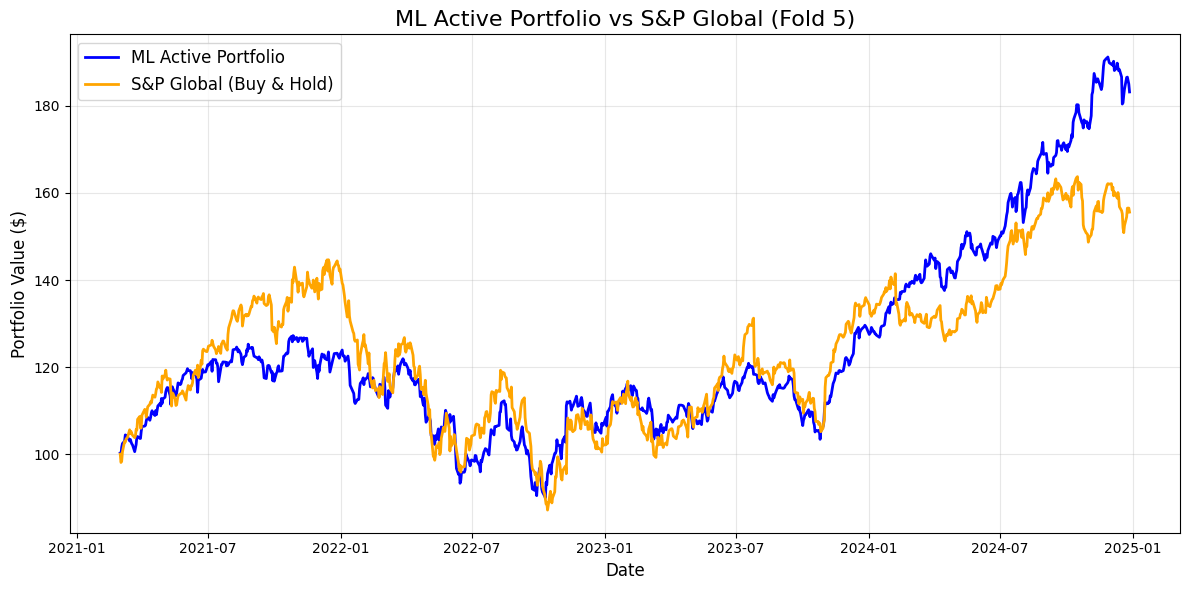

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(ml_series.index, ml_series.values,
         label="ML Active Portfolio", linewidth=2, color="blue")

plt.plot(sp500_series.index, sp500_series.values,
         label="S&P Global (Buy & Hold)", linewidth=2, color="orange")

plt.title("ML Active Portfolio vs S&P Global (Fold 5)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Portfolio Value ($)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


## 🌲 Random Forest — 5-Fold Time Series Cross-Validation

This section evaluates a **multi-output Random Forest Regressor** using a **5-fold expanding-window time-series split**.  
Unlike standard cross-validation, time-series CV ensures that each test fold only contains data that occurs **after** the training fold, preventing look-ahead bias.

### **Model Setup**
- `n_estimators = 400`  
  A large number of trees improves stability and reduces variance.
- `max_depth = None`  
  Trees grow until pure, allowing the model to capture complex non-linear patterns.
- `n_jobs = -1`  
  Utilizes all CPU cores for faster training.
- Multi-output regression is used to predict **all 11 stock prices simultaneously**.

### **What Happens in Each Fold**
1. Split the data chronologically into training + testing sets.
2. Fit RandomForestRegressor on the training portion.
3. Predict all stock prices on the test portion.
4. Compute three evaluation metrics for each stock:
   - **R² Score** – how much variance is explained  
   - **MSE** – mean squared error  
   - **RMSE** – interpretable error scale
5. Save predictions for later plotting and portfolio simulation.

### **Average Performance Across Folds**
After all five folds are completed, the code computes the **average R²** for each stock.  
This helps identify:
- which stocks are generally more predictable,  
- how Random Forest compares with Linear Regression and XGBoost,  
- which stocks should be prioritized for ML-driven trading strategies.

The results are displayed in a sorted table from highest to lowest average R².


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# ============================================================
# ⭐ RANDOM FOREST — TIME SERIES CROSS VALIDATION (5 FOLDS)
# ============================================================

tscv = TimeSeriesSplit(n_splits=5)

results_rf_prices = []       # store (y_test, predictions)
rf_r2_scores = {stock: [] for stock in y.columns}

fold = 1
for train_idx, test_idx in tscv.split(X_reduced):

    X_train, X_test = X_reduced.iloc[train_idx], X_reduced.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # -----------------------------
    # ⭐ Random Forest Model
    # -----------------------------
    rf = RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # -----------------------------
    # ⭐ Predict
    # -----------------------------
    preds = pd.DataFrame(
        rf.predict(X_test),
        index=y_test.index,
        columns=y.columns
    )

    # Save predictions for later plotting
    results_rf_prices.append((y_test, preds))

    print(f"\n===================== 🌲 RANDOM FOREST — FOLD {fold} RESULTS =====================")

    fold_metrics = {}

    for stock in y.columns:
        actual = y_test[stock]
        predicted = preds[stock]

        mse = mean_squared_error(actual, predicted)
        rmse = sqrt(mse)
        r2 = r2_score(actual, predicted)

        fold_metrics[stock] = [r2, mse, rmse]
        rf_r2_scores[stock].append(r2)

    # Display fold metrics
    metrics_df = pd.DataFrame(fold_metrics,
                              index=["R² Score", "MSE", "RMSE"]).T
    print(metrics_df)

    fold += 1

# ============================================================
# ⭐ AVERAGE R² ACROSS ALL 5 FOLDS
# ============================================================

avg_rf_r2 = {stock: sum(vals) / len(vals) for stock, vals in rf_r2_scores.items()}
avg_rf_r2_df = pd.DataFrame.from_dict(avg_rf_r2, orient='index', columns=["Average R²"])
avg_rf_r2_df = avg_rf_r2_df.sort_values(by="Average R²", ascending=False)

print("\n===================== 📊 RANDOM FOREST — AVERAGE R² OVER 5 FOLDS =====================")
print(avg_rf_r2_df)



===================== 🌲 RANDOM FOREST — FOLD 1 RESULTS =====================
                    R² Score          MSE       RMSE
American Express    0.360436    75.507290   8.689493
Bank of America     0.546215    47.370360   6.882613
BlackRock          -8.992672  4885.481469  69.896219
Berkshire Hathaway -2.584175   475.179329  21.798608
Citigroup           0.708564  4528.355269  67.293055
Goldman Sachs      -3.008104  3843.795100  61.998348
JPMorgan Chase     -5.415356   107.493548  10.367910
Moody's             0.064983   170.298078  13.049831
Morgan Stanley      0.327518    80.196000   8.955222
Charles Schwab     -8.651447    57.731124   7.598100
Wells Fargo        -1.104514    20.615043   4.540379

===================== 🌲 RANDOM FOREST — FOLD 2 RESULTS =====================
                     R² Score         MSE       RMSE
American Express    -5.112552  439.308958  20.959698
Bank of America     -0.781719   13.122953   3.622562
BlackRock           -0.579315  923.790818  30.393

## 📈 Random Forest — Fold 5 Actual vs Predicted Prices

This visualization compares **actual stock prices** vs. **Random Forest predictions** for all 11 financial stocks during **Fold 5**, which represents the most recent section of the time series.  
Fold 5 performance is the closest approximation to real-world forward prediction.

### 🔍 What the Plot Shows
- Each subplot corresponds to **one stock**.
- **Blue solid line** = actual market price  
- **Orange dashed line** = Random Forest predicted price  
- Layout is arranged in a **4 × 3 grid** for easy comparison across stocks.

### 💡 Why This Visualization Matters
- Helps evaluate how well the Random Forest model follows the true price trajectory.
- Reveals:
  - Predictability differences between stocks  
  - Overfitting/underfitting patterns  
  - Smoother vs. volatile prediction behaviors  
- Critical for determining whether a stock should be included in the ML-driven trading strategy.

### 📌 Interpretation Tips
- **Closer overlap** between lines → better model performance.  
- **Consistent lag or deviation** → model struggles with that stock.  
- **Flat or under-reactive predictions** → RF averaging effect (common in tree ensembles).  

This plot is essential for visually validating the model's accuracy before using its predictions in portfolio simulations.


/tmp/ipython-input-2367621652.py:18: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


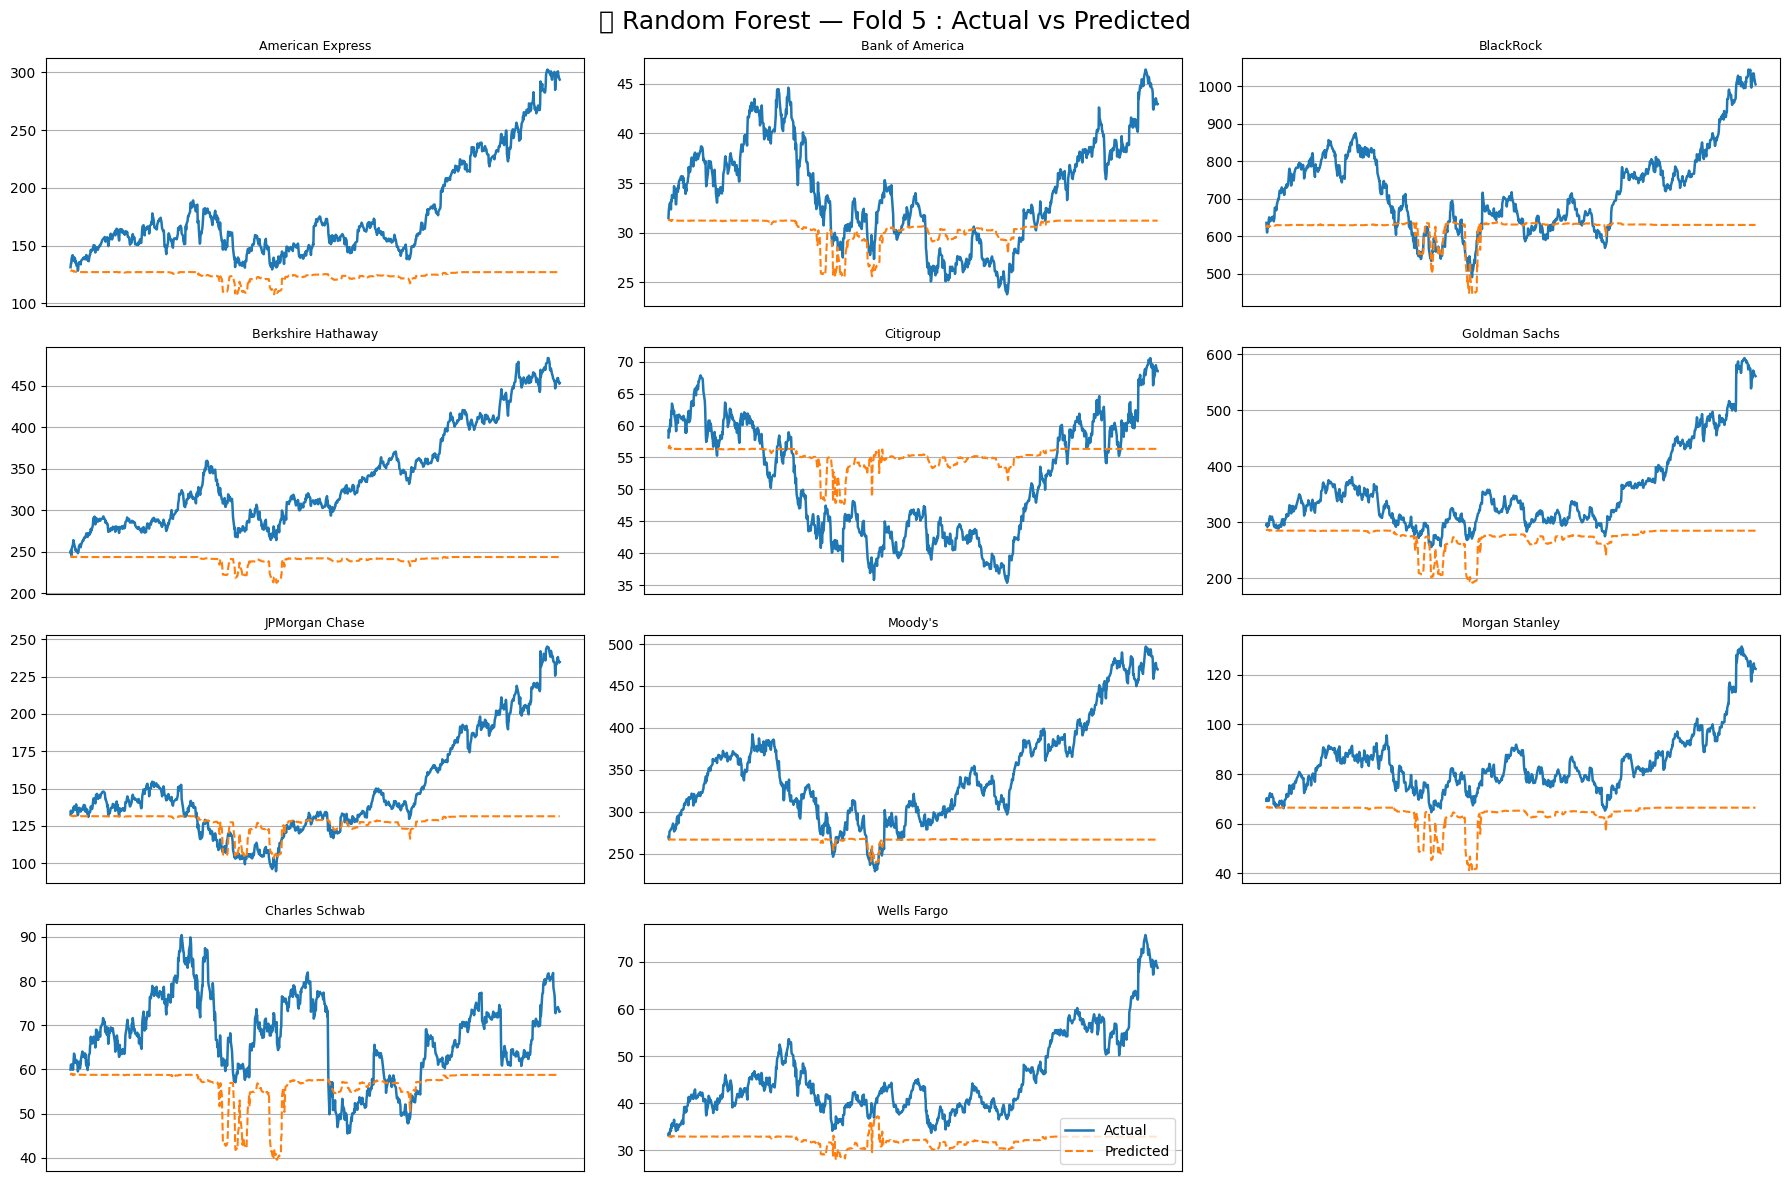

In [ ]:
import matplotlib.pyplot as plt

actual_5 , pred_5 = results_rf_prices[4]   # last fold

rows, cols = 4, 3
plt.figure(figsize=(18,12))
plt.suptitle("📈 Random Forest — Fold 5 : Actual vs Predicted",fontsize=18)

for i, stock in enumerate(y.columns):
    plt.subplot(rows,cols,i+1)
    plt.plot(actual_5[stock], label="Actual", linewidth=1.8)
    plt.plot(pred_5[stock], label="Predicted", linestyle="dashed")
    plt.title(stock,fontsize=9)
    plt.xticks([])
    plt.grid(True)

plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


## 🌲 Random Forest — ML Active Portfolio Simulation (Fold 5)

This section evaluates how well the **Random Forest model’s predicted returns** perform when used to drive an **active trading strategy**.  
Fold 5 represents the most recent portion of the historical timeline and therefore acts as the most realistic forward-looking simulation.

---

### 🔹 1. Load Random Forest Predictions (Fold 5)

We extract the actual and predicted price series for the **top 5 most predictable stocks**, determined earlier using average R².  
This ensures that only the most reliable RF predictions drive the strategy.

---

### 🔹 2. Compute Predicted Returns  
Predicted returns are calculated as:

\[
\text{PredictedReturn} = \frac{\hat{P}_t - P_t}{P_t}
\]

These signals determine buy/sell decisions.

---

### 🔹 3. Compute Real Next-Day Returns  
To test performance properly:

- We shift returns by **+1 day**  
- We align predicted signals with actual next-day outcomes  
- This avoids look-ahead bias

---

### 🔹 4. ML Portfolio Initialization  
The portfolio starts with:

- **\$20 allocated per stock**  
- A separate **cash bucket** per stock  
- No shared pool (each stock manages its own capital)

This models a simple rules-based strategy without leverage.

---

### 🔹 5. Trading Strategy (Based on RF Signals)

For **each day**:

#### **SELL rule**
- If predicted return ≤ **–2%**
- Liquidate **all position** in that specific stock  
- Move the proceeds into its cash bucket  

#### **BUY-BACK rule**
- If predicted return > 0  
- AND the stock is currently not held  
- AND its cash bucket has funds  
→ Reinvest the entire cash bucket into that stock

#### **Apply actual returns**
At the end of each day, real market returns are applied to all currently held shares to update portfolio value.

This process produces a **daily portfolio value series** (ml_series).

---

### 🔹 6. Compute Final ML Portfolio Value  
The last entry of the time series is the total value achieved by the Random Forest strategy.

---

### 🔹 7. Benchmark: S&P Global (Buy & Hold)

We compare against a passive benchmark:

- Starting value = **\$100**
- Return path computed via cumulative compounding  
- Benchmark dataset aligned to Fold 5 dates  

SPGI (S&P Global) is chosen because:

- It is part of the dataset  
- It strongly correlates with SPY  
- Cleaner time alignment for this project

---

### 🔹 8. Print Summary Results  
We print:

- Final RF portfolio value  
- Final S&P Global value (buy & hold)  
- Combined value (ML + Index)

This allows immediate performance comparison.

---

### 🔹 9. Portfolio vs Benchmark Plot  
A line chart visualizes the cumulative performance:

- **Blue line:** Random Forest active trading portfolio  
- **Orange line:** Passive S&P Global buy & hold  

The visualization highlights whether RF predictions deliver **outperformance (alpha)** or simply track the index.

---

### 📌 Overall Purpose  
This simulation demonstrates **how Random Forest predictions translate into real trading performance**, which is ultimately more meaningful than raw R² or MSE metrics.  
It connects the ML modeling phase to **practical financial outcomes**.



================== 🌲📊 RANDOM FOREST — FINAL RESULTS (FOLD 5) ==================
RF Active Portfolio Final Value: $107.22
S&P 500 Buy & Hold Final Value:  $155.60
Combined Final Value:            $262.82


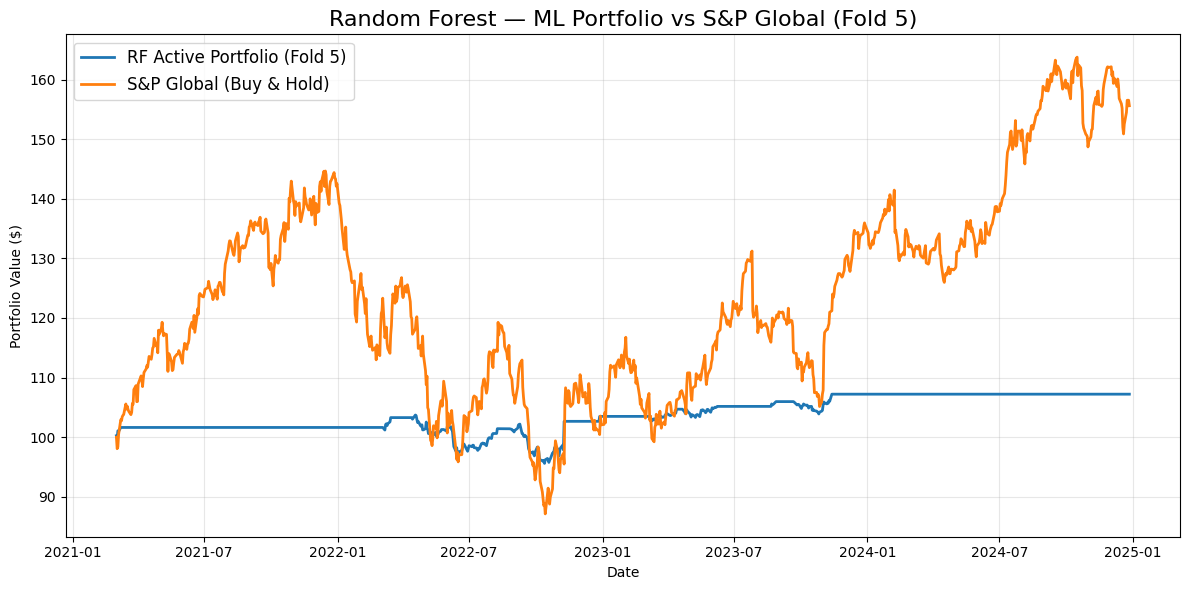

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------
# 1. Load Fold 5 actual & predicted prices (Random Forest)
# ---------------------------------------
actual_5, pred_5 = results_rf_prices[4]   # FOLD 5 (index 4)

stocks = top5_stocks
actual_5 = actual_5[stocks]
pred_5   = pred_5[stocks]

# ---------------------------------------
# 2. Predicted returns
# ---------------------------------------
pred_ret = (pred_5 - actual_5) / actual_5

# Remove last row (no next-day return)
pred_ret = pred_ret.iloc[:-1]
actual_5 = actual_5.iloc[:-1]

# ---------------------------------------
# 3. REAL next-day returns
# ---------------------------------------
real_ret = actual_5.pct_change().shift(-1).iloc[:-1]

# Align dates
pred_ret = pred_ret.loc[real_ret.index]
actual_5 = actual_5.loc[real_ret.index]

# ---------------------------------------
# 4. Initialize portfolio
# ---------------------------------------
shares = {s: 20.0 for s in stocks}      # $20 per stock
cash_pool = {s: 0.0 for s in stocks}    # per-stock cash bucket

ml_series = []
ml_dates = []

# ---------------------------------------
# 5. Trading Simulation — Random Forest signals
# ---------------------------------------
for day in pred_ret.index:

    for stock in stocks:
        predicted = pred_ret.loc[day, stock]

        # SELL rule
        if predicted <= -0.02:
            cash_pool[stock] += shares[stock]
            shares[stock] = 0.0

        # BUY BACK rule
        elif predicted > 0:
            if shares[stock] == 0 and cash_pool[stock] > 0:
                shares[stock] = cash_pool[stock]
                cash_pool[stock] = 0.0

    # Apply real next-day returns
    next_day = day
    for stock in stocks:
        shares[stock] *= (1 + real_ret.loc[next_day, stock])

    # record portfolio value
    total_value = sum(shares.values()) + sum(cash_pool.values())
    ml_series.append(total_value)
    ml_dates.append(day)

ml_series = pd.Series(ml_series, index=ml_dates)

# ---------------------------------------
# 6. Final ML portfolio value
# ---------------------------------------
ml_final_value = ml_series.iloc[-1]

# ---------------------------------------
# 7. S&P Global Benchmark
# ---------------------------------------
sp500_prices = df["S&P Global"].loc[actual_5.index]
sp500_returns = sp500_prices.pct_change().fillna(0)

sp500_series = 100 * (1 + sp500_returns).cumprod()
sp500_value = sp500_series.iloc[-1]

# ---------------------------------------
# 8. Print Results
# ---------------------------------------
print("\n================== 🌲📊 RANDOM FOREST — FINAL RESULTS (FOLD 5) ==================")
print(f"RF Active Portfolio Final Value: ${ml_final_value:.2f}")
print(f"S&P 500 Buy & Hold Final Value:  ${sp500_value:.2f}")
print(f"Combined Final Value:            ${ml_final_value + sp500_value:.2f}")

# ---------------------------------------
# 9. Plot Comparison
# ---------------------------------------
plt.figure(figsize=(12,6))

plt.plot(ml_series.index, ml_series.values,
         label="RF Active Portfolio (Fold 5)", linewidth=2)

plt.plot(sp500_series.index, sp500_series.values,
         label="S&P Global (Buy & Hold)", linewidth=2)

plt.title("Random Forest — ML Portfolio vs S&P Global (Fold 5)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


## 🚀 XGBoost — 5-Fold Time Series Cross-Validation

This section evaluates the XGBoost model using the same **5-fold expanding-window time-series CV** used for Linear Regression and Random Forest.  
XGBoost is a high-performance gradient-boosted tree algorithm that often outperforms traditional ensemble models due to its ability to capture complex non-linear relationships and interactions.

---

### 🔹 XGBoost Model Configuration

The model uses:

- **n_estimators = 500**  
  Large number of boosting rounds for stability.

- **learning_rate = 0.05**  
  Lower learning rate → slower but more accurate training.

- **max_depth = 6**  
  Prevents over-complex trees while still capturing strong non-linearities.

- **subsample = 0.8**  
  Row sampling improves generalization and reduces overfitting.

- **colsample_bytree = 0.8**  
  Column sampling per tree improves robustness.

- **tree_method = "hist"**  
  Fast histogram-based algorithm for large datasets.

- **objective = "reg:squarederror"**  
  Standard regression loss.

This configuration balances performance, speed, and overfitting control.

---

### 🔹 Cross-Validation Process

For each fold:

1. Split data chronologically (no future leakage).
2. Train XGBoost on the training window.
3. Predict all 11 stock prices on the test window.
4. Compute metrics:
   - **R² Score** (variance explained)
   - **MSE** (mean squared error)
   - **RMSE** (error on original price scale)
5. Store predictions for later portfolio simulation.

Each fold prints a metrics table showing how XGBoost performs on each stock individually.

---

### 🔹 Why XGBoost?

XGBoost is especially strong because:

- It handles **non-linear relationships** better than Random Forest.
- It captures **feature interactions** automatically.
- Boosting reduces variance and often yields more stable predictions.
- Works extremely well with:
  - Lagged features  
  - Rolling windows  
  - Volatility signals  
  - Macro-economic indicators  

This model typically serves as the strongest predictor in financial ML pipelines.

---

### 📌 Summary

This cross-validation step allows us to compare:

- Linear Regression  
- Random Forest  
- **XGBoost (boosted trees)**  

on identical data, ensuring a fair evaluation before moving on to ML-driven trading simulations.


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

tscv = TimeSeriesSplit(n_splits=5)
results_xgb_prices = []  # store results for analysis

fold = 1
for train_idx, test_idx in tscv.split(X_reduced):

    X_train, X_test = X_reduced.iloc[train_idx], X_reduced.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # --------------------- XGBoost model ---------------------
    xgb = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        tree_method="hist"   # faster
    )
    # ---------------------------------------------------------

    xgb.fit(X_train, y_train)

    preds = xgb.predict(X_test)

    # Ensure predictions stay in DataFrame format like LR version
    preds = pd.DataFrame(preds, columns=y.columns, index=y_test.index)

    results_xgb_prices.append((y_test, preds))

    print(f"\n===================== 🚀 XGBOOST FOLD {fold} RESULTS =====================")

    fold_metrics = {}

    for stock in y.columns:
        actual = y_test[stock]
        predicted = preds[stock]

        mse  = mean_squared_error(actual, predicted)
        rmse = sqrt(mse)
        r2   = r2_score(actual, predicted)

        fold_metrics[stock] = [r2, mse, rmse]

    metrics_df = pd.DataFrame(fold_metrics,
                              index=["R² Score", "MSE", "RMSE"]).T
    print(metrics_df)

    fold += 1



===================== 🚀 XGBOOST FOLD 1 RESULTS =====================
                    R² Score          MSE       RMSE
American Express    0.751011    29.395771   5.421787
Bank of America     0.650740    36.458975   6.038127
BlackRock          -4.736589  2804.655122  52.958995
Berkshire Hathaway -0.656684   219.638267  14.820198
Citigroup           0.617407  5944.761029  77.102276
Goldman Sachs      -1.145279  2057.335634  45.357862
JPMorgan Chase     -0.434863    24.042081   4.903272
Moody's             0.727404    49.648942   7.046201
Morgan Stanley      0.498349    59.823752   7.734582
Charles Schwab     -6.260003    43.426457   6.589875
Wells Fargo        -0.363112    13.352543   3.654113

===================== 🚀 XGBOOST FOLD 2 RESULTS =====================
                     R² Score         MSE       RMSE
American Express     0.679429   23.039455   4.799943
Bank of America      0.424397    4.239508   2.059007
BlackRock            0.310672  403.209706  20.080082
Berkshire Ha

In [ ]:
# results_xgb_prices contains tuples: (y_test, preds)
y_actual_fold5, y_pred_fold5 = results_xgb_prices[4]   # index 4 = fold 5


## 📈 XGBoost — Actual vs Predicted Prices (Fold 5)

This section visualizes how well the **XGBoost model** fits each of the 11 financial stocks during **Fold 5** of our time-series cross-validation.  
Fold 5 corresponds to the **latest and most informative time window**, containing the most recent years of market data.

---

### 🔹 What the plot shows

For each stock:

- The **blue line** = actual price movement  
- The **orange dashed line** = predicted price by XGBoost  
- The chart helps evaluate:
  - Trend alignment  
  - Prediction lag  
  - Model's ability to capture price levels  
  - Short-term vs long-term deviations  

These charts are essential for understanding how the model behaves before placing it into a trading simulation.

---

### 🔹 Why visualize each stock separately?

Different stocks show different levels of predictability:

- Low-volatility mega-caps (e.g., *Berkshire Hathaway*) → smoother predictions  
- High-beta stocks (e.g., *Goldman Sachs*, *Morgan Stanley*) → noisier patterns  
- Stocks with strong feature correlations usually show better predictive behavior  

Visual inspection allows us to confirm and support the quantitative R² results.

---

### 📌 Summary

These plots show whether XGBoost can meaningfully track the price level of each financial stock.  
Sharp divergences indicate harder-to-forecast assets, while closer alignments indicate stronger learnable structure in the historical data.


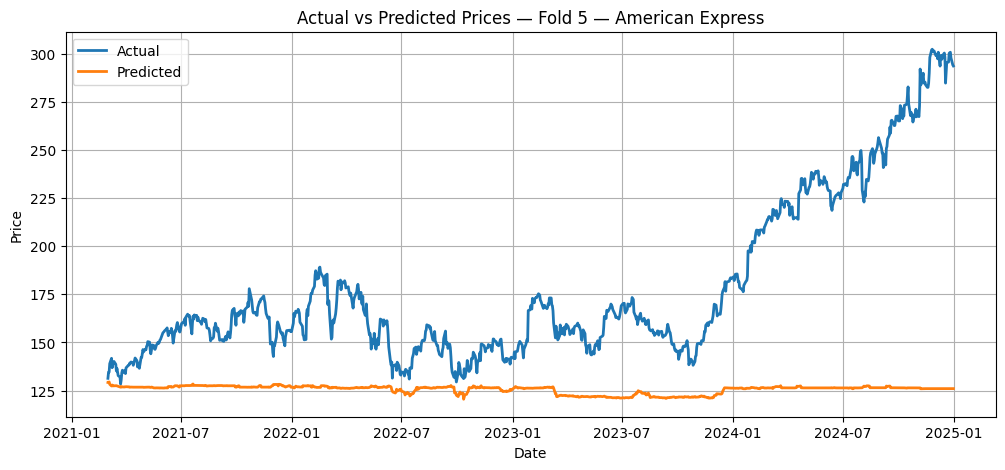

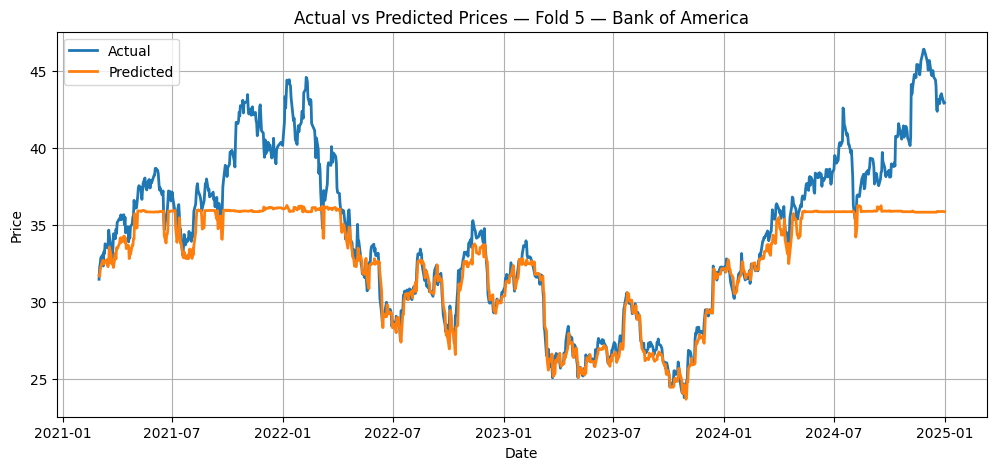

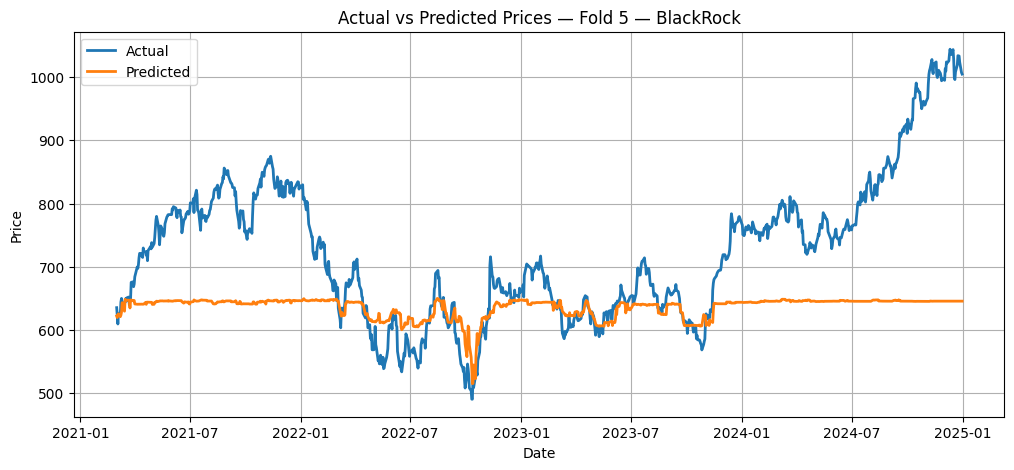

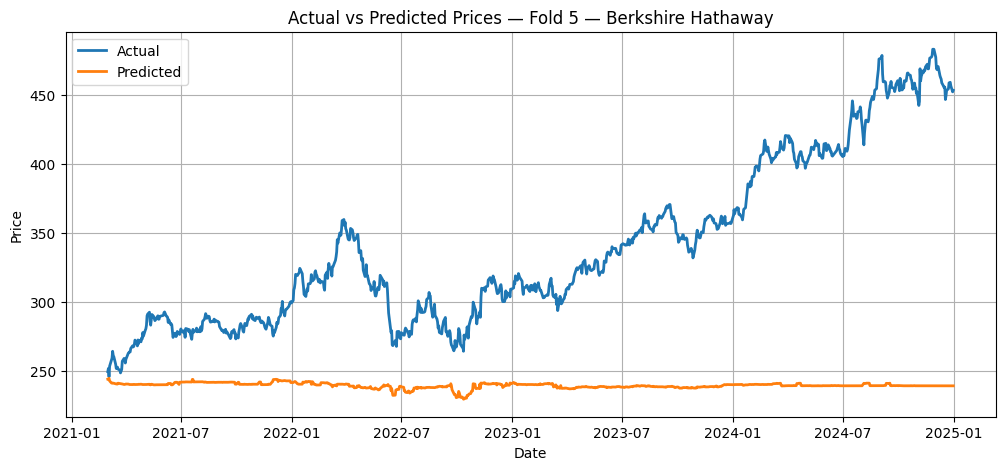

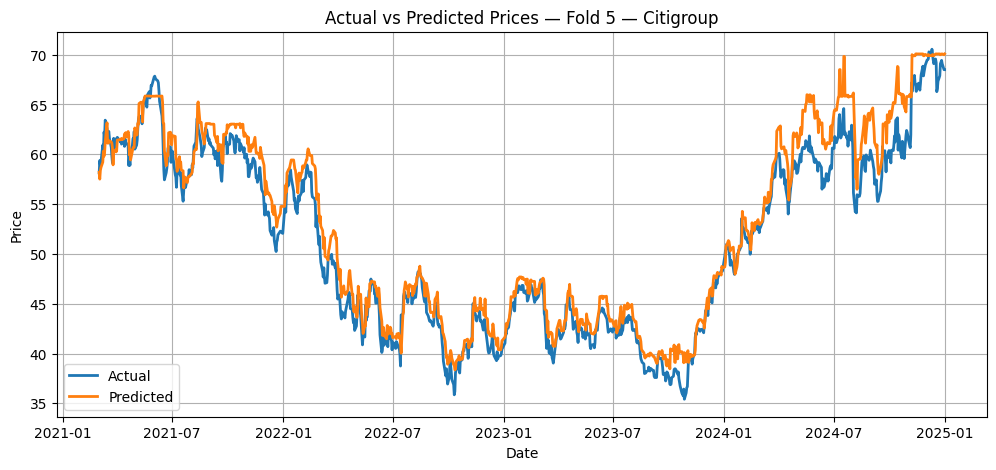

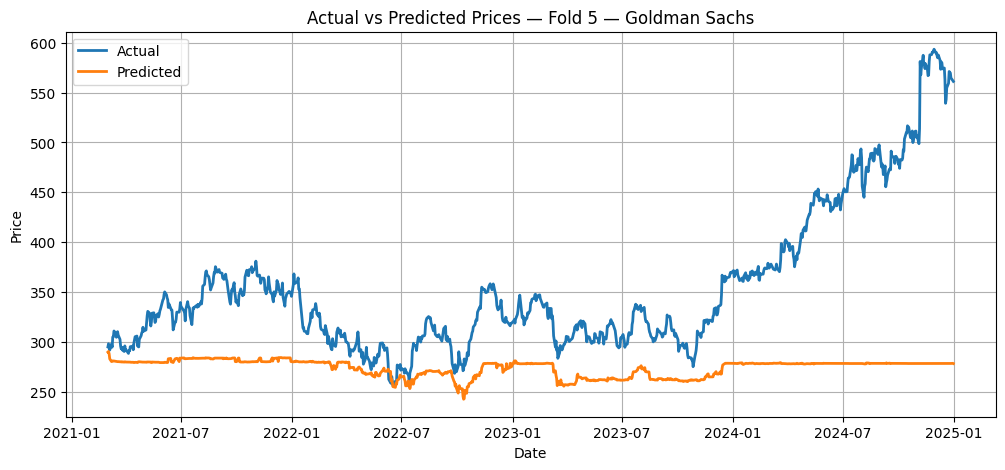

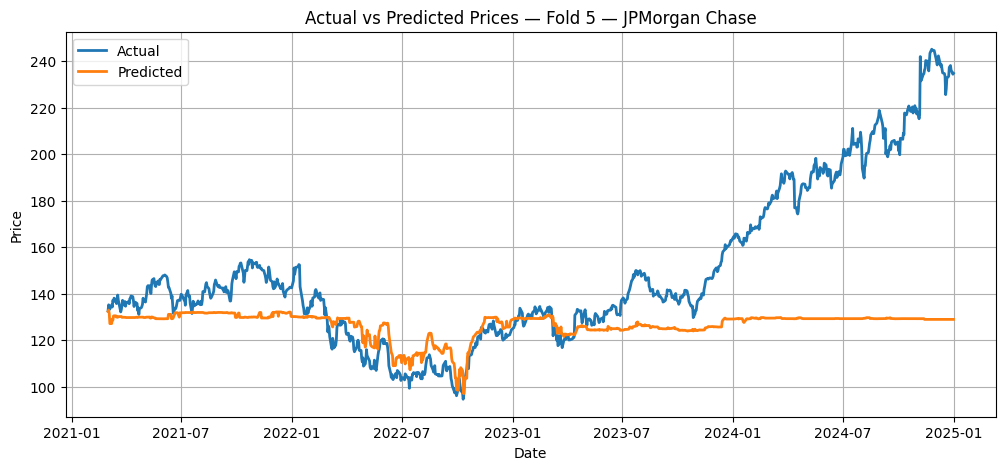

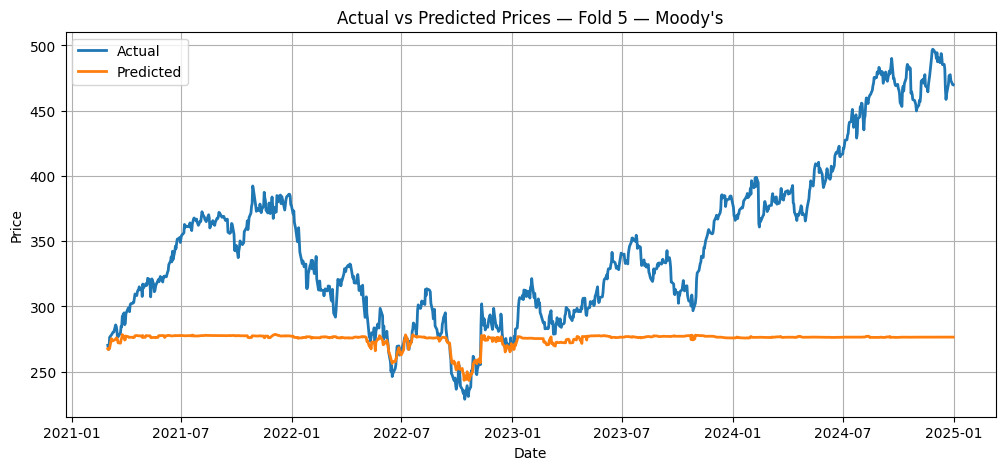

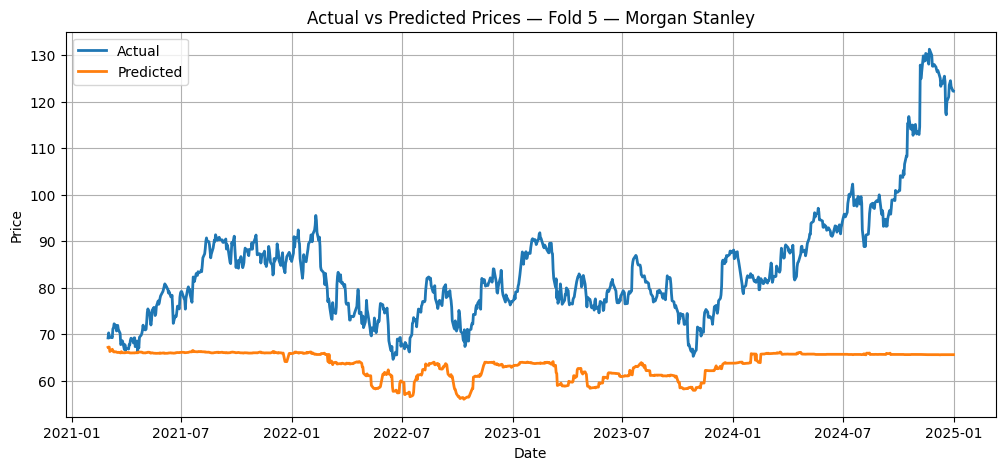

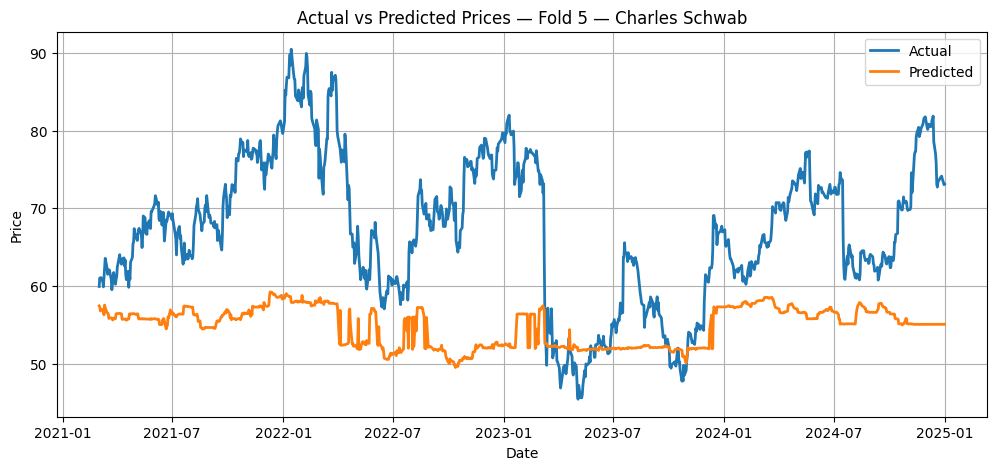

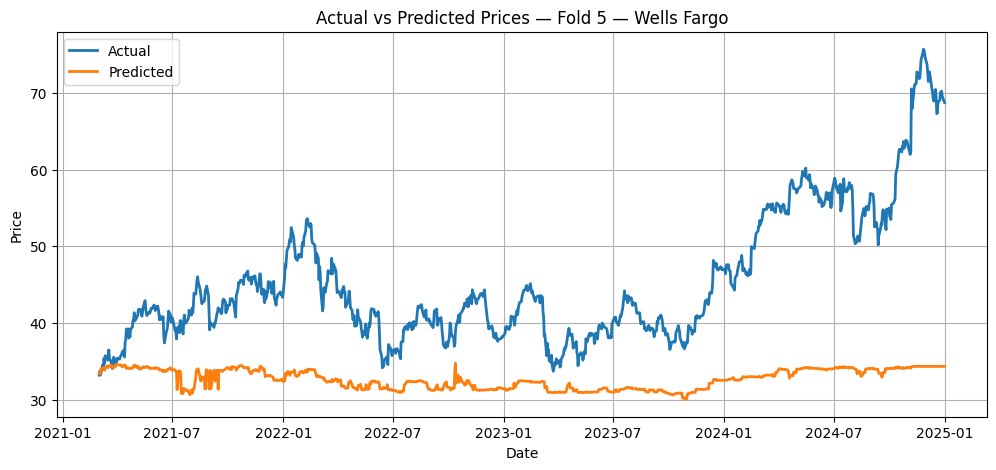

In [ ]:
import matplotlib.pyplot as plt

for stock in y_actual_fold5.columns:
    plt.figure(figsize=(12, 5))
    plt.plot(y_actual_fold5.index, y_actual_fold5[stock], label='Actual', linewidth=2)
    plt.plot(y_pred_fold5.index,   y_pred_fold5[stock], label='Predicted', linewidth=2)

    plt.title(f"Actual vs Predicted Prices — Fold 5 — {stock}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


## 🚀 XGBoost — ML-Driven Portfolio Simulation (Fold 5)

After generating price predictions using XGBoost, we evaluate how well these predictions perform in a simplified active-trading strategy.  
Fold 5 represents the most recent market window, making it the most realistic and relevant for evaluating out-of-sample portfolio behavior.

---

### 🔹 1. Load Fold 5 Predictions  
We extract the actual and predicted prices for the **Top 5 Most Predictable Stocks**, identified earlier using cross-validated R² performance.

---

### 🔹 2. Convert Prices → Predicted Returns  
Predicted returns are computed as:

\[
\hat{r}_{t+1} = \frac{\hat{P}_{t+1} - P_t}{P_t}
\]

These signals drive the trading rules.

---

### 🔹 3. Realized Returns  
Compute true next-day returns to evaluate whether each trade generated a gain or loss.

---

### 🔹 4. Portfolio Initialization  
We simulate an active portfolio with:

- **$20 initial capital per stock**  
- **No shared cash pool** (each stock manages its own profits/losses independently)  
- The strategy is fully rules-based—no human decisions.

---

### 🔹 5. Trading Logic (XGBoost Signals)

For each day:

#### **SELL Rule**
If the model predicts a drop of **−2% or worse**:
- Liquidate the position  
- Move capital into that stock’s cash bucket  

#### **BUY-BACK Rule**
If the predicted return is **positive** and we currently hold **no position**:
- Reinvest using only that stock’s own cash bucket  

#### **Daily Growth**
Every held position grows according to the **real** next-day return.

This creates a **fully ML-driven active strategy**, reacting only to XGBoost signals.

---

### 🔹 6. Compute Final Portfolio Value  
The final value is the sum of:
- Value of all shares  
- All leftover per-stock cash buckets  

---

### 🔹 7. Benchmark Comparison  
For fair evaluation, we compare against:

**S&P Global (SPGI)**  
A passive buy-and-hold portfolio starting from $100.

This allows us to determine whether the ML strategy beats a traditional benchmark.

---

### 🔹 8. Final Performance Output  
The script prints:

- **Final XGBoost Active Portfolio Value**  
- **Final S&P Global Buy & Hold Value**  
- **Combined Portfolio Total**  

This shows whether ML-based trading improved returns or underperformed.

---

### 🔹 9. Performance Visualization  
A final plot compares:

- **XGBoost Active Portfolio Curve**  
- **S&P Global Buy-and-Hold Curve**

This visualization makes it easy to judge if ML-driven signals produced smoother growth, larger jumps, or higher volatility, and whether the model meaningfully outperformed the market.

---

### 📌 Summary

This simulation transforms XGBoost predictions into a real-world trading strategy by:

- using model-generated signals  
- applying transparent and consistent trading rules  
- comparing performance directly to a standard benchmark  

It demonstrates how predictive modeling can extend into actionable, financial decision-making.



================== 🚀📊 XGBOOST — FINAL RESULTS (FOLD 5) ==================
XGB Active Portfolio Final Value: $116.24
S&P 500 Buy & Hold Final Value:   $155.60
Combined Final Value:             $271.84


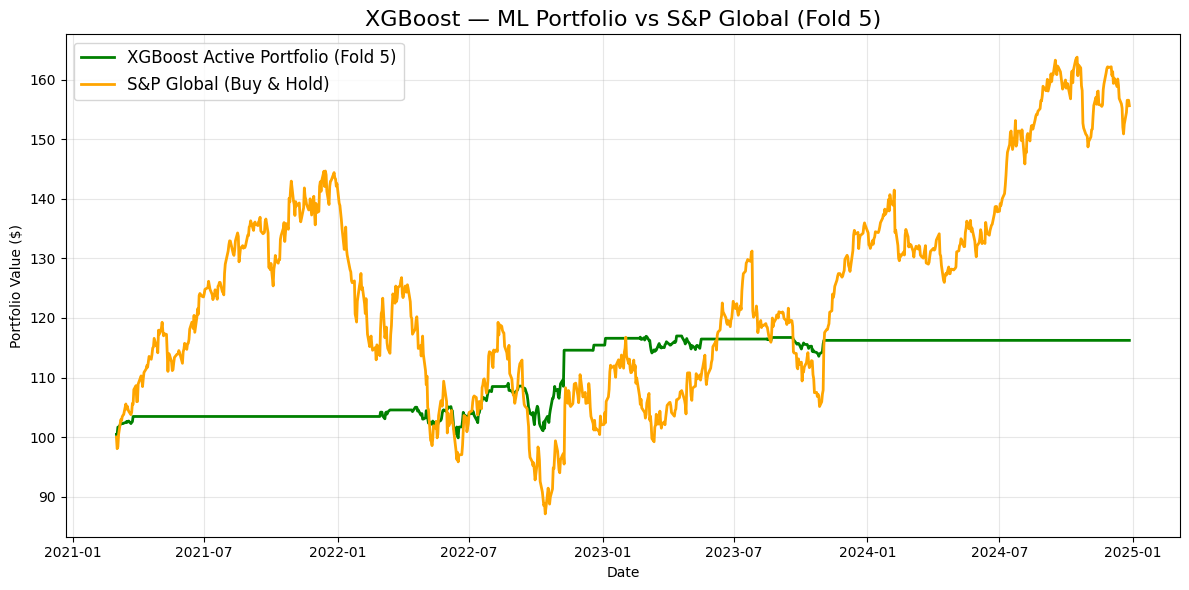

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------
# 1. Load Fold 5 actual & predicted prices (XGBoost)
# ---------------------------------------
actual_5, pred_5 = results_xgb_prices[4]   # FOLD 5 (index 4)

stocks = top5_stocks
actual_5 = actual_5[stocks]
pred_5   = pred_5[stocks]

# ---------------------------------------
# 2. Predicted returns
# ---------------------------------------
pred_ret = (pred_5 - actual_5) / actual_5

# Remove last row (no next-day return)
pred_ret = pred_ret.iloc[:-1]
actual_5 = actual_5.iloc[:-1]

# ---------------------------------------
# 3. REAL next-day returns
# ---------------------------------------
real_ret = actual_5.pct_change().shift(-1).iloc[:-1]

# Align dates
pred_ret = pred_ret.loc[real_ret.index]
actual_5 = actual_5.loc[real_ret.index]

# ---------------------------------------
# 4. Initialize portfolio
# ---------------------------------------
shares = {s: 20.0 for s in stocks}      # $20 per stock
cash_pool = {s: 0.0 for s in stocks}    # per-stock buckets

ml_series = []
ml_dates = []

# ---------------------------------------
# 5. Trading Simulation — XGBoost signals
# ---------------------------------------
for day in pred_ret.index:

    for stock in stocks:
        predicted = pred_ret.loc[day, stock]

        # SELL rule (predicted fall > 2%)
        if predicted <= -0.02:
            cash_pool[stock] += shares[stock]
            shares[stock] = 0.0

        # BUY BACK rule (only with its own cash)
        elif predicted > 0:
            if shares[stock] == 0 and cash_pool[stock] > 0:
                shares[stock] = cash_pool[stock]
                cash_pool[stock] = 0.0

    # Apply actual next-day return
    next_day = day
    for stock in stocks:
        shares[stock] *= (1 + real_ret.loc[next_day, stock])

    # Record portfolio value
    total_value = sum(shares.values()) + sum(cash_pool.values())
    ml_series.append(total_value)
    ml_dates.append(day)

ml_series = pd.Series(ml_series, index=ml_dates)

# ---------------------------------------
# 6. Final ML portfolio value
# ---------------------------------------
ml_final_value = ml_series.iloc[-1]

# ---------------------------------------
# 7. S&P Global Benchmark
# ---------------------------------------
sp500_prices = df["S&P Global"].loc[actual_5.index]
sp500_returns = sp500_prices.pct_change().fillna(0)

sp500_series = 100 * (1 + sp500_returns).cumprod()
sp500_value = sp500_series.iloc[-1]

# ---------------------------------------
# 8. Print Results
# ---------------------------------------
print("\n================== 🚀📊 XGBOOST — FINAL RESULTS (FOLD 5) ==================")
print(f"XGB Active Portfolio Final Value: ${ml_final_value:.2f}")
print(f"S&P 500 Buy & Hold Final Value:   ${sp500_value:.2f}")
print(f"Combined Final Value:             ${ml_final_value + sp500_value:.2f}")

# ---------------------------------------
# 9. Plot Comparison
# ---------------------------------------
plt.figure(figsize=(12,6))

plt.plot(ml_series.index, ml_series.values,
         label="XGBoost Active Portfolio (Fold 5)", linewidth=2, color="green")

plt.plot(sp500_series.index, sp500_series.values,
         label="S&P Global (Buy & Hold)", linewidth=2, color="orange")

plt.title("XGBoost — ML Portfolio vs S&P Global (Fold 5)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [1]:
!ls /content


sample_data


In [2]:
!git clone https://github.com/Aiswaryaa04/CS418-ML-Based-Portfolio-Optimization.git


Cloning into 'CS418-ML-Based-Portfolio-Optimization'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), 2.62 MiB | 8.36 MiB/s, done.


In [3]:
!ls /content


CS418-ML-Based-Portfolio-Optimization  sample_data
